# README


* Purposes of this Code:
    * Use Gala package to integrate orbits and calculate actions for the Marchetti Subset


* Marchetti Subset:
    * https://arxiv.org/abs/1804.10607 


* Packages Required:
    * astropy: http://www.astropy.org/
    * numpy: http://www.numpy.org/
    * matplotlib: https://matplotlib.org/
    * gala: https://gala-astro.readthedocs.io/en/latest/index.html
    

* Assumed Constants:
    * $X_\odot$ = -8 kpc
    * $Y_\odot$ = 0 kpc
    * $Z_\odot$ = 25 pc

In [1]:
#Importing required packages
import astropy.units as u
from astropy.table import Table 
import matplotlib.pyplot as plt
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

In [2]:
#Reading in Marchetti data and creating variables in kpc and km/s
data_table = Table.read('/home/douglas/data.fits', format = 'fits') 
U = np.array(data_table["U"])
V = np.array(data_table["V"])
W = np.array(data_table["W"])   
X = np.array(data_table["xGC"])*0.001        
Y = np.array(data_table["yGC"])*0.001
Z = np.array(data_table["zGC"])*0.001



In [3]:
#Creating potential instance
pot = gp.MilkyWayPotential(units=galactic) #galactic = Myr; M_sun; kpc

#Creating initial conditions for first Marchetti source
ics = gd.PhaseSpacePosition(pos=[X[0],Y[0],Z[0]] * u.kpc,
                            vel=[U[0],V[0],W[0]] * u.km/u.s)

In [4]:
#Creating time range.
N = 100000
ts = np.linspace(0,10,N)  #Gyr
dt = (ts[1]-ts[0]) * 1000  #Converting Myr to Gyr

#Creating orbit
orbit = gp.Hamiltonian(pot).integrate_orbit(ics, dt=dt, n_steps=N)

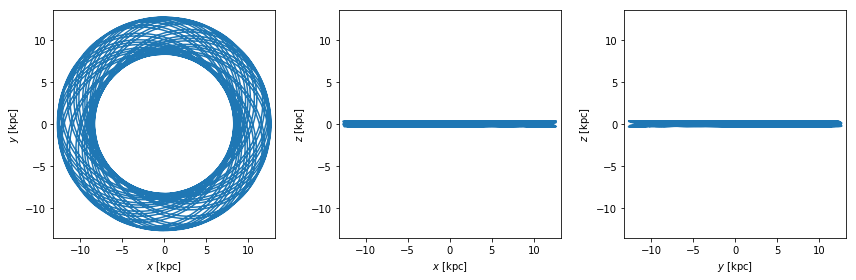

In [5]:
#Plotting orbit
fig = orbit.plot()

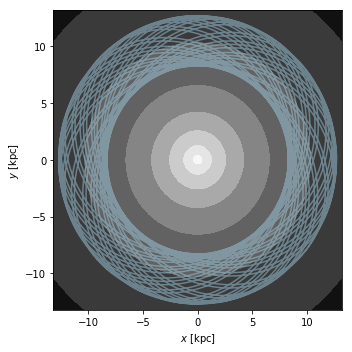

In [6]:
#Plotting orbit on top of potential contour plot
grid = np.linspace(-15,15,64)
fig,ax = plt.subplots(1, 1, figsize=(5,5))
fig = pot.plot_contours(grid=(grid,grid,0), cmap='Greys', ax=ax)
fig = orbit.plot(['x', 'y'], color='#9ecae1', alpha=0.5,
                      axes=[ax], auto_aspect=False)

# $\Phi_{eff}$ Graphs

In [7]:
#Creating x axis as the X distance
N = 100000
R_plot = np.array(np.linspace(2, 20, N))

#Creating quantity array and filling it with zeros
Phi_x = np.zeros(N) *u.kpc*u.kpc/(u.Myr*u.Myr)

#Allocating the energy at each point of x-axis to the array. Loop takes a while
for i in range(0,N):
    Phi_x[i] = pot.energy([R_plot[i],0,0]*u.kpc)[0]

#Printing to make sure it worked
print(pot.energy([R_plot[0],0,0]))
print(Phi_x[0])

[-0.23717756] kpc2 / Myr2
-0.23717756360114373 kpc2 / Myr2


In [8]:
#Calculating Lz for all Marchetti sources
Lz = (X*V - Y*U)  #kpc km/s

#Calculating R for first Marchetti source
R1 = (X[0]**2 + Y[0]**2)**0.5  #kpc

#Calculating centrifugal potential
Phi_cfx = (Lz[0]**2/R_plot**2)*0.5  #km^2/s^2

#Creating constant of conversion
km2s2_kpc2Myr2 = 1.044522198621241344e-6

#Converting cf potential to right units
Phi_cfx = Phi_cfx * km2s2_kpc2Myr2 *u.kpc*u.kpc/(u.Myr*u.Myr)

#Creating Effective potential
Phi_eff = Phi_cfx + Phi_x

#Calculating Vrad squared term and converting to correct units
V_rad2 = (U*X + V*Y)**2/(X**2 + Y**2)
V_rad2 = V_rad2 * km2s2_kpc2Myr2 *u.kpc*u.kpc/(u.Myr*u.Myr)

#Calculating potentials for first Marchetti source
Phi1 = pot.energy([X[0],Y[0],Z[0]]*u.kpc)
Phicf1 = (Lz[0]**2/R1**2)*0.5 * km2s2_kpc2Myr2 *u.kpc*u.kpc/(u.Myr*u.Myr)

#Calculating total energy for first Marchetti source
E = 0.5*(V_rad2[0]) + Phicf1  + Phi1

(-0.15, -0.1)

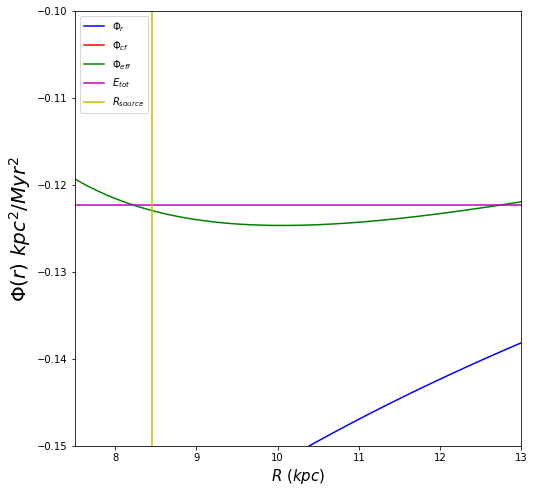

In [10]:
#Plotting the 3 potentials with different colors
from astropy.visualization import quantity_support
quantity_support()

plt.figure(figsize=(8,8))
plt.plot(R_plot, Phi_x, c='b',label = '$\Phi_r$')
plt.plot(R_plot, Phi_cfx, c='r', label = '$\Phi_{cf}$')
plt.plot(R_plot, Phi_eff, c='g', label = '$\Phi_{eff}$')
plt.axhline(E, c='m', label = '$E_{tot}$')
plt.axvline(R1, c='y', label = '$R_{source}$')

plt.legend(loc='upper left')
plt.xlabel("$R\ (kpc)$", fontsize=15)
plt.ylabel("$\Phi(r)\ kpc^2/Myr^2$", fontsize=20)
plt.xlim(7.5,13)
plt.ylim(-0.15,-0.1)

# Action Calculations

Text(0,0.5,'$\\theta_3$ [rad]')

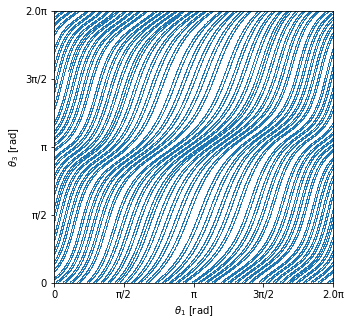

In [10]:
import astropy.coordinates as coord

#First compute actions in a toy potential
toy_potential = gd.fit_isochrone(orbit)

#See that they are not correct because they should be straight lines
toy_actions,toy_angles,toy_freqs = toy_potential.action_angle(orbit)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(toy_angles[0], toy_angles[2], linestyle='none', marker=',') 
ax.set_xlim(0,2*np.pi) 
ax.set_ylim(0,2*np.pi) 
ax.set_xlabel(r"$\theta_1$ [rad]") 
ax.set_ylabel(r"$\theta_3$ [rad]") 

Text(0,0.5,'$J_1$ [rad]')

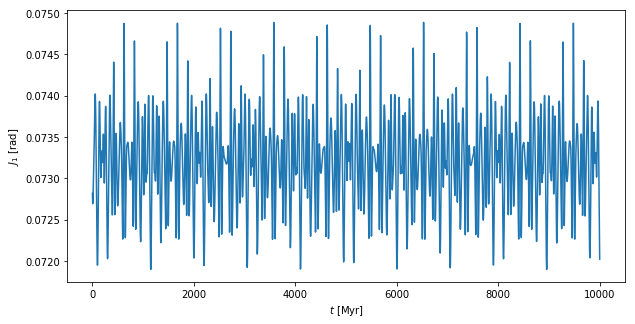

In [11]:
#Also plot action as function of time
fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(orbit.t, toy_actions[0], marker='') 
ax.set_xlabel(r"$t$ [Myr]") 
ax.set_ylabel(r"$J_1$ [rad]") 

In [12]:
# find approximations to the actions in the true potential
import warnings
with warnings.catch_warnings(record=True):
    warnings.simplefilter("ignore")
    result = gd.find_actions(orbit, N_max=8, toy_potential=toy_potential)

In [13]:
lz = (X[0]*V[0] - Y[0]*U[0])*u.kpc*u.km/u.s

print(lz.to(u.kpc*u.kpc/u.Myr))
#kpc2/Myr

-2.342992504617018 kpc2 / Myr


In [14]:
result['actions'] 

<Quantity [ 7.32300338e-02, -2.34299250e+00,  2.34012800e-03] kpc2 / Myr>

In [51]:
result['angles']

<Quantity [0.32848585, 3.26998689, 4.63977802] rad>

In [52]:
result['freqs']

<Quantity [ 0.02978446, -0.02192194,  0.04789624] 1 / Myr>

In [15]:
#To visualize how the actions are computed, again plot the actions in the toy potential and then 
#plot the “corrected” actions – the approximation to the actions computed using this machinery:
nvecs = gd.generate_n_vectors(8, dx=1, dy=2, dz=2) 
act_correction = nvecs.T[...,None] * result['Sn'][None,:,None] * np.cos(nvecs.dot(toy_angles))[None] 
action_approx = toy_actions - 2*np.sum(act_correction, axis=1)*u.kpc**2/u.Myr 

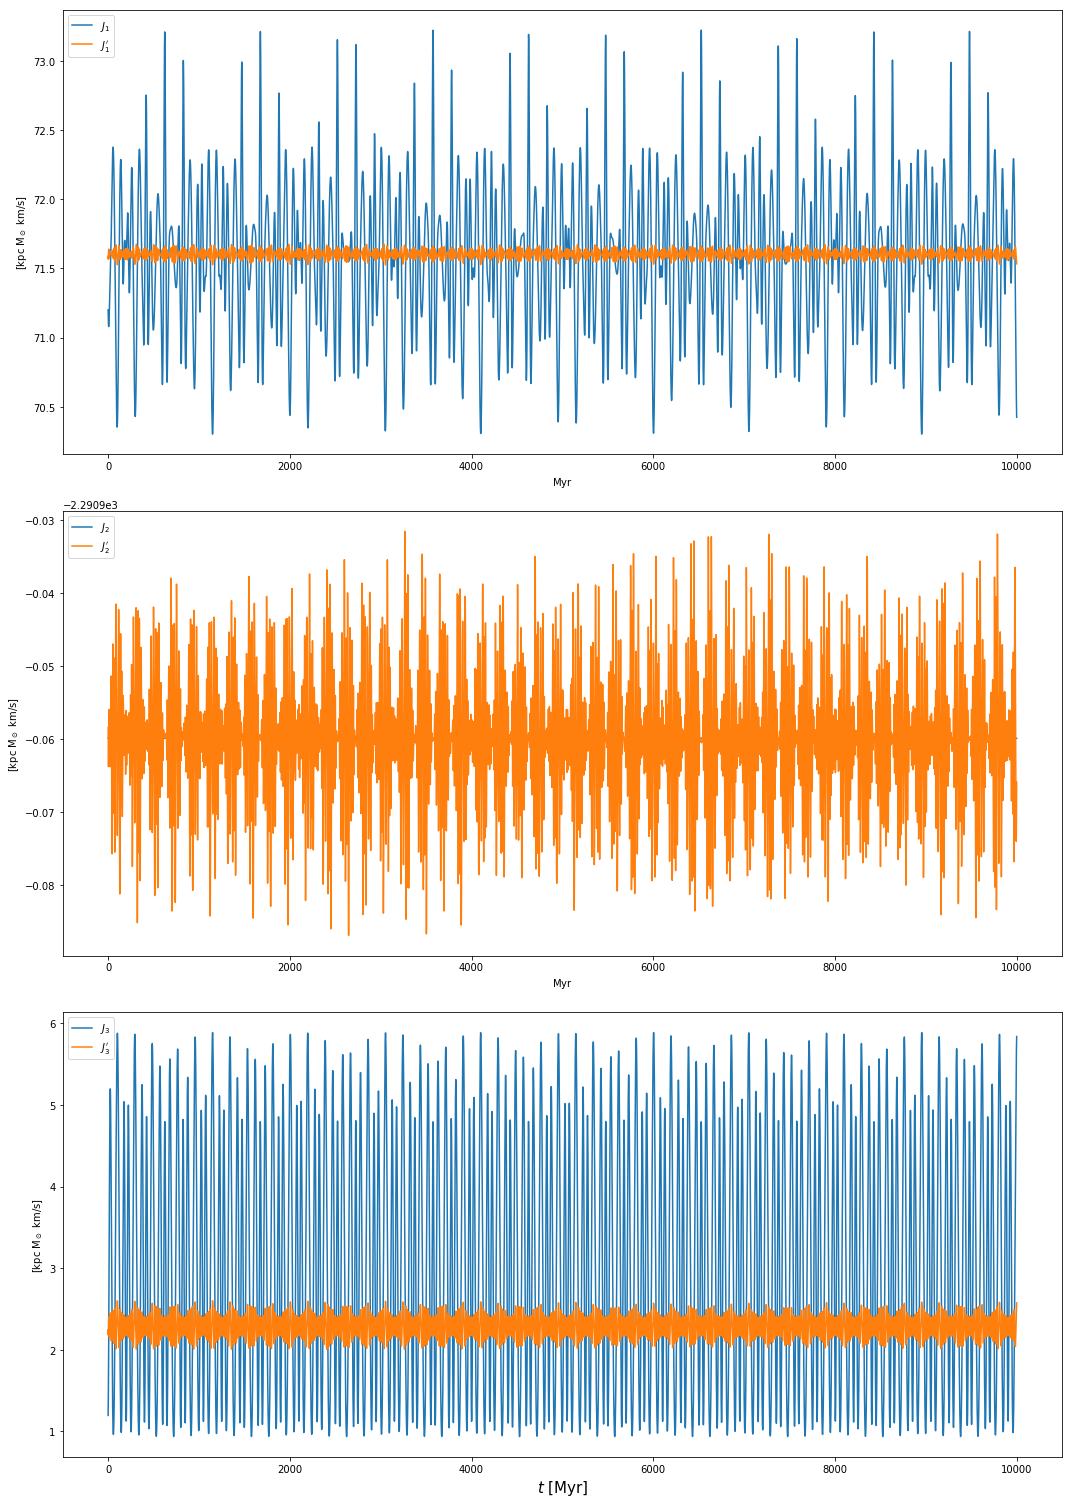

In [16]:
# for visualization, compute the action correction used to transform the
# toy potential actions to the approximate true potential actions.
fig,axes = plt.subplots(3,1,figsize=(15,21))

for i,ax in enumerate(axes):
    ax.plot(orbit.t, toy_actions[i].to(u.km/u.s*u.kpc), marker='', label='$J_{}$'.format(i+1))
    ax.plot(orbit.t, action_approx[i].to(u.km/u.s*u.kpc), marker='', label="$J_{}'$".format(i+1))
    ax.set_ylabel(r"[kpc ${\rm M}_\odot$ km/s]")
    ax.legend(loc='upper left')

ax.set_xlabel(r"$t$ [Myr]",fontsize=15)
fig.tight_layout()

(-2291, -2290.8)

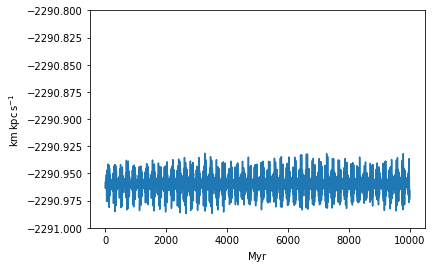

In [17]:
plt.plot(orbit.t, action_approx[1].to(u.km/u.s*u.kpc))
plt.ylim(-2291, -2290.8)

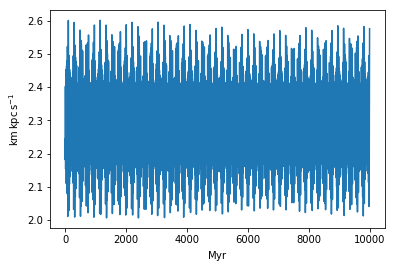

In [18]:
plt.plot(orbit.t, action_approx[2].to(u.km/u.s*u.kpc))
#plt.ylim(-2291, -2290.8)

In [19]:
print(toy_actions[1].to(u.km/u.s*u.kpc))

[-2290.95984645 -2290.95984645 -2290.95984645 ... -2290.95984645
 -2290.95984645 -2290.95984645] km kpc / s


In [20]:
print(X[0]*V[0] - Y[0]*U[0])

-2290.959846452962


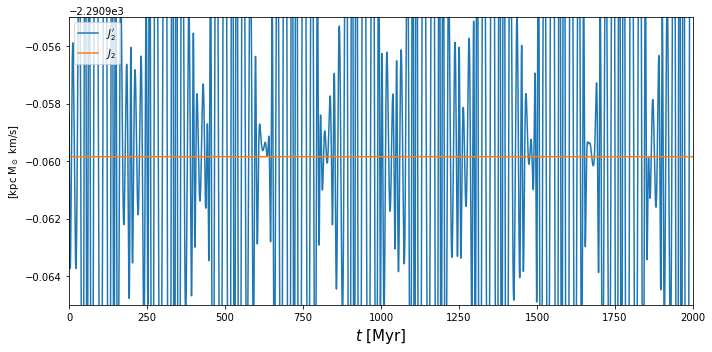

In [21]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(orbit.t, action_approx[1].to(u.km/u.s*u.kpc), marker='', label="$J_{}'$".format(2))
ax.plot(orbit.t, toy_actions[1].to(u.km/u.s*u.kpc), marker='', label='$J_{}$'.format(2))
ax.set_ylabel(r"[kpc ${\rm M}_\odot$ km/s]")
ax.legend(loc='upper left')
ax.set_xlabel(r"$t$ [Myr]",fontsize=15)
plt.xlim(0,2000)
plt.ylim(-0.065-2.2909e3,-0.055-2.2909e3)
fig.tight_layout()

# Selecting Stars close to Sun

In [22]:
#Centering around Sun
X = X + 8

#Creating cylindrical coordinate R
R = X**2 + Y**2

#Selecting stars around 100 pc of Sun
ichoose = np.where((R < 0.01))

#Creating empty arrays and filling them with zeros.
Close_X = np.zeros(len(ichoose[0])-1)
Close_Y = np.zeros(len(ichoose[0])-1)      
Close_Z = np.zeros(len(ichoose[0])-1)      
Close_U = np.zeros(len(ichoose[0])-1)
Close_V = np.zeros(len(ichoose[0])-1)
Close_W = np.zeros(len(ichoose[0])-1)
Close_source = np.zeros(len(ichoose[0])-1)

#Adding the selected stars to the arrays and 
#converting to Galactocentric coord and kpc.
for i in range(0,len(ichoose[0])-1):
    Close_X[i] = X[ichoose[0][i]]
    Close_Y[i] = Y[ichoose[0][i]]
    Close_Z[i] = Z[ichoose[0][i]]
    Close_U[i] = U[ichoose[0][i]]
    Close_V[i] = V[ichoose[0][i]]
    Close_W[i] = W[ichoose[0][i]]
    Close_source = data_table['source_id'][ichoose[0][i]]

#Making it Galactocentric again
Close_X = Close_X - 8

In [23]:
#function for first if statement in loop below. For further details check:
#https://gala-astro.readthedocs.io/en/latest/_modules/gala/dynamics/actionangle.html#fit_isochrone
def f(p,w):
        logm,b = p
        potential = IsochronePotential(m=np.exp(logm), b=b, units=pot.units)
        H = potential.value(w[:3]).decompose(pot.units).value + 0.5*np.sum(w[3:]**2, axis=0)
        return np.squeeze(H - np.mean(H))

In [24]:
#Retrieving source id from Marchetti Data
source = data_table["source_id"]

#importing necessary packages and functions
from gala.potential import (Hamiltonian, IsochronePotential)
from scipy.optimize import leastsq

#Defining arrays and filling them with zeros
actions = np.zeros(shape=(len(Close_X),3))
angles = np.zeros(shape=(len(Close_X),3))
freq = np.zeros(shape=(len(Close_X),3))
source_id = np.zeros(len(Close_X))

In [25]:
#Crazy loop to calculate actions. Takes like two days to run. 

for i in range(0, len(Close_X)):
    #Defining Phase Space
    phase = gd.PhaseSpacePosition(pos=[Close_X[i], Close_Y[i], Close_Z[i]] *u.kpc,
                            vel=[Close_U[i], Close_V[i], Close_W[i]] *u.km/u.s)
    
    #Integrating orbit
    orb = gp.Hamiltonian(pot).integrate_orbit(phase, dt=0.1, n_steps=10000)
    
    #Making absolute sure toy potentials can be calculated for orbit: For further details check: 
    #https://gala-astro.readthedocs.io/en/latest/_modules/gala/dynamics/actionangle.html#fit_isochrone
    w = np.squeeze(orb.w(pot.units)) 
    logm0 = np.log(2e11)
    p,ier = leastsq(f, np.array([logm0, 1]), args=(w,))
    
    if ier >= 1 and ier <= 4.:
    
        #Creating toy potential
        toy = gd.fit_isochrone(orb)
        
        #Calculating energy for toy potential for the next if statement.
        #For further details check:
        #https://gala-astro.readthedocs.io/en/latest/_modules/gala/dynamics/analyticactionangle.html#isochrone_to_aa
        E2 = orb.energy(Hamiltonian(toy)).decompose(toy.units).value
        E2 = np.squeeze(E2)
        
        #Making absolute sure orbits are bounded
        if np.all(E2 < 0.):
            print(i)
            with warnings.catch_warnings(record=True):
                warnings.simplefilter("ignore")
                #Calculating and appending appropriate variables
                results = gd.find_actions(orb, N_max=8, toy_potential=toy)
                actions[i,:] = results['actions']
                angles[i,:] = results['angles']
                freq[i,:] = results['freqs']
                source_id[i] = source[i]
#done

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
2

1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071


3516
3517
3518
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5627
5628
5629
5630
5631
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672


7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9920
9921
9922
9923
9925
9926
9927
9928
9929
9930
9931
9933
9934
9935
9937
9938


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9972
9973
9975
9976
9977


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


9979
9980
9981
9983
9984
9985
9986
9987
9988
9989
9990
9991
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10053
10054
10055
10056
10057


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


10059
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
1038

11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
1176

12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
1313

14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
1450

15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
1588

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


16607
16608
16609
16610


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705
16706
16707
16708
16709
16710
16711
16712
16713
16714
16715
16716
16717
16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729
16730
16731
16732
16733
16734
16735
16736
16737
16738
16739
16740
16741
16742
16743
16744
16745
16746
16747
16748
16749
16750
16751
16752
16753
16754
16755
16756
16757
16758
16759
16760
16761
16762
16763
16764
16765
16766
16767
16768
16769
16770
16771
16772
16773
16774
16775
16776
16777
1677

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
17856
17857
17858
1785

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
18747
18748
18749
18750
18751
18752
18753
18754
18755
18756
18757
18758
18759
18760
18761
18762
18763
18764
18765
18766
18767
18768
18769
18770
18771
18772
18773
18774
18775
18776
18777
18778
18779
18780
18781
18782
18783
18784
18785
18786
18787
18788
18789
18790
18791
18792
18793
18794
18795
18796
18797
18798
18799
18800
18801
18802
18803
18804
18805
18806
18807
18808
18809
18810
18811
18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872
18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
18891
18892
18893
18894
18895
1889

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
1995

21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
2132

22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
2269

23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
2406

25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
25427
25428
2542

26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
2679

28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
2816

29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
2953

30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
3090

32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
3227

33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
3364

34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
3501

36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
36227
36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
3638

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


36750
36751
36752
36753
36754
36755
36756
36757
36758
36759
36760
36761
36762
36763
36764
36765
36766
36767
36768
36769
36770
36771
36772
36773
36774
36775
36776
36777
36778
36779
36780
36781
36782
36783
36784
36785
36786
36787
36788
36789
36790
36791
36792
36793
36794
36795
36796
36797
36798
36799
36800
36801
36802
36803
36804
36805
36806
36807
36808
36809
36810
36811
36812
36813
36814
36815
36816
36817
36818
36819
36820
36821
36822
36823
36824
36825
36826
36827
36828
36829
36830
36831
36832
36833
36834
36835
36836
36837
36838
36839
36840
36841
36842
36843
36844
36845
36846
36847
36848
36849
36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
36866
36867
36868
36869
36870
36871
36872
36873
36874
36875
36876
36877
36878
36879
36880
36881
36882
36883
36884
36885
36886
36887
36888
36889
36890
36891
36892
36893
36894
36895
36896
36897
36898
36899
36900
36901
36902
36903
36904
36905
36906
36907
36908
36909
36910
36911
36912
36913
36914
36915
3691

38120
38121
38122
38123
38124
38125
38126
38127
38128
38129
38130
38131
38132
38133
38134
38135
38136
38137
38138
38139
38140
38141
38142
38143
38144
38145
38146
38147
38148
38149
38150
38151
38152
38153
38154
38155
38156
38157
38158
38159
38160
38161
38162
38163
38164
38165
38166
38167
38168
38169
38170
38171
38172
38173
38174
38175
38176
38177
38178
38179
38180
38181
38182
38183
38184
38185
38186
38187
38188
38189
38190
38191
38192
38193
38194
38195
38196
38197
38198
38199
38200
38201
38202
38203
38204
38205
38206
38207
38208
38209
38210
38211
38212
38213
38214
38215
38216
38217
38218
38219
38220
38221
38222
38223
38224
38225
38226
38227
38228
38229
38230
38231
38232
38233
38234
38235
38236
38237
38238
38239
38240
38241
38242
38243
38244
38245
38246
38247
38248
38249
38250
38251
38252
38253
38254
38255
38256
38257
38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
3828

39489
39490
39491
39492
39493
39494
39495
39496
39497
39498
39499
39500
39501
39502
39503
39504
39505
39506
39507
39508
39509
39510
39511
39512
39513
39514
39515
39516
39517
39518
39519
39520
39521
39522
39523
39524
39525
39526
39527
39528
39529
39530
39531
39532
39533
39534
39535
39536
39537
39538
39539
39540
39541
39542
39543
39544
39545
39546
39547
39548
39549
39550
39551
39552
39553
39554
39555
39556
39557
39558
39559
39560
39561
39562
39563
39564
39565
39566
39567
39568
39569
39570
39571
39572
39573
39574
39575
39576
39577
39578
39579
39580
39581
39582
39583
39584
39585
39586
39587
39588
39589
39590
39591
39592
39593
39594
39595
39596
39597
39598
39600
39601
39602
39603
39604
39605
39606
39607
39608
39609
39610
39611
39612
39613
39614
39615
39616
39617
39618
39619
39620
39621
39622
39623
39624
39625
39626
39627
39628
39629
39630
39631
39632
39633
39634
39635
39636
39637
39638
39639
39640
39641
39642
39643
39644
39645
39646
39647
39648
39649
39650
39651
39652
39653
39654
39655
3965

40859
40860
40861
40862
40864
40865
40866
40867
40868
40869
40870
40871
40872
40873
40874
40875
40876
40877
40878
40879
40880
40881
40882
40883
40884
40885
40886
40887
40888
40889
40890
40891
40892
40893
40894
40895
40896
40897
40898
40899
40900
40901
40902
40903
40904
40905
40906
40907
40908
40909
40910
40911
40912
40913
40914
40915


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


40917
40918
40919
40920
40921
40922
40923
40924
40925
40926
40927
40928
40929
40930
40931
40932
40933
40934
40935
40936
40937
40938
40939
40940
40941
40942
40943
40944
40945
40946
40947
40948
40949
40950
40951
40952
40953
40954
40955
40956
40957
40958
40959
40960
40961
40962
40963
40964
40965
40966
40967
40968
40969
40970
40971
40972
40973
40974
40975
40976
40977
40978
40979
40980
40981
40982
40983
40984
40985
40986
40987
40988
40989
40990
40991
40992
40993
40994
40995
40996
40997
40998
40999
41000
41001
41002
41003
41004
41005
41006
41007
41008
41009
41010
41011
41012
41013
41014
41015
41016
41017
41018
41019
41020
41021
41022
41023
41024
41025
41026
41027
41028
41029
41030
41031
41032
41033
41034
41035
41036
41037
41038
41039
41040
41041
41042
41043
41044
41045
41046
41047
41048
41049
41050
41051
41052
41053
41054
41055
41056
41057
41058
41059
41060
41061
41062
41063
41064
41065
41066
41067
41068
41069
41070
41071
41072
41073
41074
41075
41076
41077
41078
41079
41080
41081
41082
4108

42294
42295
42296
42297
42298
42299
42300
42301
42302
42303
42304
42305
42306
42307
42308
42309
42310
42311
42312
42313
42314
42315
42316
42317
42318
42319
42320
42321
42322
42323
42324
42325
42326
42327
42328
42329
42330
42331
42332
42333
42334
42335
42336
42337
42338
42339
42340
42341
42342
42343
42344
42345
42346
42347
42348
42349
42350
42351
42352
42353
42354
42355
42356
42357
42358
42359
42360
42361
42362
42363
42364
42365
42366
42367
42368
42369
42370
42371
42372
42373
42374
42375
42376
42377
42378
42379
42380
42381
42382
42383
42384
42385
42386
42387
42388
42389
42390
42391
42392
42393
42394
42395
42396
42397
42398
42399
42400
42401
42402
42403
42404
42405
42406
42407
42408
42410
42411
42412
42413
42414
42415
42416
42417
42418
42419
42420
42421
42422
42423
42424
42425
42426
42427
42428
42429
42430
42431
42432
42433
42434
42435
42436
42437
42438
42439
42440
42441
42442
42443
42444
42445
42446
42447
42448
42449
42450
42451
42452
42453
42454
42455
42456
42457
42458
42459
42460
4246

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


42767
42768
42769
42770
42771
42772
42773
42774
42775
42776
42777
42778
42779
42780
42781
42782
42783
42784
42785
42786
42787
42788
42789
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866
42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
4293

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


43277
43278
43279
43280
43281
43282
43283
43284
43285
43286
43287
43288
43289
43290
43291
43292
43293
43294
43295
43296
43297
43298
43299
43300
43301
43302
43303
43304
43305
43306
43307
43308
43309
43310
43311
43312
43313
43314
43315
43316
43317
43318
43319
43320
43321
43322
43323
43324
43325
43326
43327
43328
43329
43330
43331
43332
43333
43334
43335
43336
43337
43338
43339
43340
43341
43342
43343
43344
43345
43346
43347
43348
43349
43350
43351
43352
43353
43354
43355
43356
43357
43358
43359
43360
43361
43362
43363
43364
43365
43366
43367
43368
43369
43370
43371
43372
43373
43374
43375
43376
43377
43378
43379
43380
43381
43382
43383
43384
43385
43386
43387
43388
43389
43390
43391
43392
43393
43394
43395
43396
43397
43398
43399
43400
43401
43402
43403
43404
43405
43406
43407
43408
43409
43410
43411
43412
43413
43414
43415
43416
43417
43418
43419
43420
43421
43422
43423
43424
43425
43426
43427
43428
43429
43430
43431
43432
43433
43434
43435
43436
43437
43438
43439
43440
43441
43442
4344

44646
44647
44648
44649
44650
44651
44652
44653
44654
44655
44656
44657
44658
44659
44660
44661
44662
44663
44664
44665
44666
44667
44668
44669
44670
44671
44672
44673
44674
44675
44676
44677
44678
44679
44680
44681
44682
44683
44684
44685
44686
44687
44688
44689
44690
44691
44692
44693
44694
44695
44696
44697
44698
44699
44700
44701
44702
44703
44704
44705
44706
44707
44708
44709
44710
44711
44712
44713
44714
44715
44716
44717
44718
44719
44720
44721
44722
44723
44724
44725
44726
44727
44728
44729
44730
44731
44732
44733
44734
44735
44736
44737
44738
44739
44740
44741
44742


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


44744
44745
44746
44747
44748
44749
44750
44751
44752
44753
44754
44755
44756
44757
44758
44759
44760
44761
44762
44763
44764
44765
44766
44767
44768
44769
44770
44771
44772
44773
44774
44775
44776
44777
44778
44779
44780
44781
44782
44783
44784
44785
44786
44787
44788
44789
44791
44792
44793
44794
44795
44796
44797
44798
44799
44800
44801
44802
44803
44804
44805
44806
44807
44808
44809
44810
44811
44812
44813
44814
44815
44816
44817
44818
44819
44820
44821
44822
44823
44824
44825
44826
44827
44828
44829
44830
44831
44832
44833
44834
44835
44836
44837
44838
44839
44840
44841
44842
44843
44844
44845
44846
44847
44848
44849
44850
44851
44852
44853
44854
44855
44856
44857
44858
44859
44860
44861
44862
44863
44864
44865
44866
44867
44868
44869
44870
44871
44872
44873
44874
44875
44876
44877
44878
44879
44880
44881
44882
44883
44884
44885
44886
44887
44888
44889
44890
44891
44892
44893
44894
44895
44896
44897
44898
44899
44900
44901
44902
44903
44904
44905
44906
44907
44908
44909
44910
4491

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
45122
45123
45124
45125
45126
45127
45128
45129
45130
45131
45132
45133
45134
45135
45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
45148
45149
45150
45151
45152
45153
45154
45155
45156
45157
45158
45159
45160
45161
45162
45163
45164
45165
45166
45167
45168
45169
45170
45171
45172
45173
45174
45175
45176
45177
45178
45179
45180
45181
45182
45183
45184
45185
45186
45187
45188
45189
45190
45191
45192
45193
45194
45195
45196
45197
45198
45199
45200
45201
45202
45203
45204
45205
45206
45207
45208
45209
45210
45211
45212
45213
45214
45215
45216
45217
45218
45219
45220
45221
45222
45223
45224
45225
45226
45227
45228
45229
45230
45231
45232
45233
45234
45235
45236
45237
45238
45239
45240
45241
45242
45243
45244
45245
45246
45247
45248
45249
45250
45251
45252
45253
45254
45255
45256
45257
45258
45259
45260
45261
45262
45263
45264
45265
45266
4526

46473
46474
46475
46476
46477
46478
46479
46480
46481
46482
46483
46484
46485
46486
46487
46488
46489
46490
46491
46492
46493
46494
46495
46496
46497
46498
46499
46500
46501
46502
46503
46504
46505
46506
46507
46508
46509
46510
46511
46512
46513
46514
46515
46516
46517
46518
46519
46520
46521
46522
46523
46524
46525
46526
46527
46528
46529
46530
46531
46532
46533
46534
46535
46536
46537
46538
46539
46540
46541
46542
46543
46544
46545
46546
46547
46548
46549
46550
46551
46552
46553
46554
46555
46556
46557
46558
46559
46560
46561
46562
46563
46564
46565
46566
46567
46568
46569
46570
46571
46572
46573
46574
46575
46576
46577
46578
46579
46580
46581
46582
46583
46584
46585
46586
46587
46588
46589
46590
46591
46592
46593
46594
46595
46596
46597
46598
46599
46600
46601
46602
46603
46604
46605
46606
46607
46608
46609
46610
46611
46612
46613
46614
46615
46616
46617
46618
46619
46620
46621
46622
46623
46624
46625
46626
46627
46628
46629
46630
46631
46632
46633
46634
46635
46636
46637
46638
4663

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


47618
47619
47620
47621
47622
47623
47624
47625
47626
47627
47628
47629
47630
47631
47632
47633
47634
47635
47636
47637
47638
47639
47640
47641
47642
47643
47644
47645
47646
47647
47648
47649
47650
47651
47652
47653
47654
47655
47656
47657
47658
47659
47660
47661
47662
47663
47664
47665
47666
47667
47668
47669
47670
47671
47672
47673
47674
47675
47676
47677
47678
47679
47680
47681
47682
47683
47684
47685
47686
47687
47688
47689
47690
47691
47692
47693
47694
47695
47696
47697
47698
47699
47700
47701
47702
47703
47704
47705
47706
47707
47708
47709
47710
47711
47712
47713
47714
47715
47716
47717
47718
47719
47720
47721
47722
47723
47724
47725
47726
47727
47728
47729
47730
47731
47732
47733
47734
47735
47736
47737
47738
47739
47740
47741
47742
47743
47744
47745
47746
47747
47748
47749
47750
47751
47752
47753
47754
47755
47756
47757
47758
47759
47760
47761
47762
47763
47764
47765
47766
47767
47768
47769
47770
47771
47772
47773
47774
47775
47776
47777
47778
47779
47780
47781
47782
47783
4778

48987
48988
48989
48990
48991
48992
48993
48994
48995
48996
48997
48998
48999
49000
49001
49002
49003
49004
49005
49006
49007
49008
49009
49010
49011
49012
49013
49014
49015
49016
49017
49018
49019
49020
49021
49022
49023
49024
49025
49026
49027
49028
49029
49030
49031
49032
49033
49034
49035
49036
49037
49038
49039
49040
49041
49042
49043
49044
49045
49046
49047
49048
49049
49050
49051
49052
49053
49054
49055
49056
49057
49058
49059
49060
49061
49062
49063
49064
49065
49066
49067
49068
49069
49070
49071
49072
49073
49074
49075
49076
49077
49078
49079
49080
49081
49082
49083
49084
49085
49086
49087
49088
49089
49090
49091
49092
49093
49094
49095
49096
49097
49098
49099
49100
49101
49102
49103
49104
49105
49106
49107
49108
49109
49110
49111
49112
49113
49114
49115
49116
49117
49118
49119
49120
49121
49122
49123
49124
49125
49126
49127
49128
49129
49130
49131
49132
49133
49134
49135
49136
49137
49138
49139
49140
49141
49142
49143
49144
49145
49146
49147
49148
49149
49150
49151
49152
4915

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50055
50056
50057
50058
50059
50060
50061
50062
50063
50064
50065
50066
50067
50068
50069
50070
50071
50072
50073
50074
50075
50076
50077
50078
50079
50080
50081
50082
50083
50084
50085
50086
50087
50088
50089
50090
50091
50092
50093
50094
50095
50096
50097
50098
50099
50100
50101
5010

51302
51303
51304
51305
51306
51307
51308
51309
51310
51311
51312
51313
51314
51315
51316
51317
51318
51319
51320
51321
51322
51323
51324
51325
51326
51327
51328
51329
51330
51331
51332
51333
51334
51335
51336
51337
51338
51339
51340
51341
51342
51343
51344
51345
51346
51347
51348
51349
51350
51351
51352
51353
51354
51355
51356
51357
51358
51359
51360
51361
51362
51363
51364
51365
51366
51367
51368
51369
51370
51371
51372
51373
51374
51375
51376
51377
51378
51379
51380
51381
51382
51383
51384
51385
51386
51387
51388
51389
51390
51391
51392
51393
51394
51395
51396
51397
51398
51399
51400
51401
51402
51403
51404
51405
51406
51407
51408
51409
51410
51411
51412
51413
51414
51415
51416
51417
51418
51419
51420
51421
51422
51423
51424
51425
51426
51427
51428
51429
51430
51431
51432
51433
51434
51435
51436
51437
51438
51439
51440
51441
51442
51443
51444
51445
51446
51447
51448
51449
51450
51451
51452
51453
51455
51456
51457
51458
51459
51460
51461
51462
51463
51464
51465
51466
51467
51468
5146

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


51717
51718
51719
51720
51721
51722
51723
51724
51725
51726
51727
51728
51729
51730
51731
51732
51733
51734
51735
51736
51737
51738
51739
51740
51741
51742
51743
51744
51745
51746
51747
51748
51749
51750
51751
51752
51753
51754
51755
51756
51757
51758
51759
51760
51761
51762
51763
51764
51765
51766
51767
51768
51769
51770
51771
51772
51773
51774
51775
51776
51777
51778
51779
51780
51781
51782
51783
51784
51785
51786
51787
51788
51789
51790
51791
51792
51793
51794
51795
51796
51797
51798
51799
51800
51801
51802
51803
51804
51805
51806
51807
51808
51809
51810
51811
51812
51813
51814
51815
51816
51817
51818
51819
51820
51821
51822
51823
51824
51825
51826
51827
51828
51829
51830
51831
51832
51833
51834
51835
51836
51837
51838
51839
51840
51841
51842
51843
51844
51845
51846
51847
51848
51849
51850
51851
51852
51853
51854
51855
51856
51857
51858
51859
51860
51861
51862
51863
51864
51865
51866
51867
51868
51869
51870
51871
51872
51873
51874
51875
51876
51877
51878
51879
51880
51881
51882
5188

53087
53088
53089
53090
53091
53092
53093
53094
53095
53096
53097
53098
53099
53100
53101
53102
53103
53104
53105
53106
53107
53108
53109
53110
53111
53112
53113
53114
53115
53116
53117
53118
53119
53120
53121
53122
53123
53124
53125
53126
53127
53128
53129
53130
53131
53132
53133
53134
53135
53136
53137
53138
53139
53140
53141
53142
53143
53144
53145
53146
53147
53148
53149
53150
53151
53152
53153
53154
53155
53156
53157
53158
53159
53160
53161
53162
53163
53164
53165
53166
53167
53168
53169
53170
53171
53172
53173
53174
53175
53176
53177
53178
53179
53180
53181
53182
53183
53184
53185
53186
53187
53188
53189
53190
53191
53192
53193
53194
53195
53196
53197
53198
53199
53200
53201
53202
53203
53204
53205
53206
53207
53208
53209
53210
53211
53212
53213
53214
53215
53217
53218
53220
53221
53222
53223
53224
53225
53226
53227
53228
53229
53230
53231
53232
53233
53234
53235
53236
53237
53238
53239
53240
53241
53242
53243
53244
53245
53246
53247
53248
53249
53250
53251
53252
53253
53254
5325

54459
54460
54461
54462
54463
54464
54465
54466
54467
54468
54469
54470
54471
54472
54473
54474
54475
54476
54477
54478
54479
54480
54481
54482
54483
54484
54485
54486
54487
54488
54489
54490
54491
54492
54493
54494
54495
54496
54497
54498
54499
54500
54501
54502
54503
54504
54505
54506
54507
54508
54509
54510
54511
54512
54513
54514
54515
54516
54517
54518
54519
54520
54521
54522
54523
54524
54525
54526
54527
54528
54529
54530
54531
54532
54533
54534
54535
54536
54537
54538
54539
54540
54541
54542
54543
54544
54545
54546
54547
54548
54549
54550
54551
54552
54553
54554
54555
54556
54557
54558
54559
54560
54561
54562
54563
54564
54565
54566
54567
54568
54569
54570
54571
54572
54573
54574
54575
54576
54577
54578
54579
54580
54581
54582
54583
54584
54585
54586
54587
54588
54589
54590
54591
54592
54593
54594
54595
54596
54597
54598
54599
54600
54601
54602
54603
54604
54605
54606
54607
54608
54609
54610
54611
54612
54613
54614
54615
54616
54617
54618
54619
54620
54621
54622
54623
54624
5462

55828
55829
55830
55831
55832
55833
55834
55835
55836
55837
55838
55839
55840
55841
55842
55843
55844
55845
55846
55847
55848
55849
55850
55851
55852
55853
55854
55855
55856
55857
55858
55859
55860
55861
55862
55863
55864
55865
55866
55867
55868
55869
55870
55871
55872
55873
55874
55875
55876
55877
55878
55879
55880
55881
55882
55883
55884
55885
55886
55887
55888
55889
55890
55891
55892
55893
55894
55895
55896
55897
55898
55899
55900
55901
55902
55903
55904
55905
55906
55907
55908
55909
55910
55911
55912
55913
55914
55915
55916
55917
55918
55919
55920
55921
55922
55923
55924
55925
55926
55927
55928
55929
55930
55931
55932
55933
55934
55935
55936
55937
55938
55939
55940
55941
55942
55943
55944
55945
55946
55947
55948
55949
55950
55951
55952
55953
55954
55955
55956
55957
55958
55959
55960
55961
55962
55963
55964
55965
55966
55967
55968
55969
55970
55971
55972
55973
55974
55975
55976
55977
55978
55979
55980
55981
55982
55983
55984
55985
55986
55987
55988
55989
55990
55991
55992
55993
5599

57196
57197
57198
57199
57200
57201
57202
57203
57204
57205
57206
57207
57208
57209
57210
57211
57212
57213
57214
57215
57216
57217
57218
57219
57220
57221
57222
57223
57224
57225
57226
57227
57228
57229
57230
57231
57232
57233
57234
57235
57236
57237
57238
57239
57240
57241
57242
57243
57244
57245
57246
57247
57248
57249
57250
57251
57252
57253
57254
57255
57256
57257
57258
57259
57260
57261
57262
57263
57264
57265
57266
57267
57268
57269
57270
57271
57272
57273
57274
57275
57276
57277
57278
57279
57280
57281
57282
57283
57284
57285
57286
57287
57288
57289
57290
57291
57292
57293
57294
57295
57296
57297
57298
57299
57300
57301
57302
57303
57304
57305
57306
57307
57308
57309
57310
57311
57312
57313
57314
57315
57316
57317
57318
57319
57320
57321
57322
57323
57324
57325
57326
57327
57328
57329
57330
57331
57332
57333
57334
57335
57336
57337
57338
57339
57340
57341
57342
57343
57344
57345
57346
57347
57348
57349
57350
57351
57352
57353
57354
57355
57356
57357
57358
57359
57360
57361
5736

58566
58567
58568
58569
58570
58571
58572
58573
58574
58575
58576
58577
58578
58579
58580
58581
58582
58583
58584
58585
58586
58587
58588
58589
58590
58591
58592
58593
58594
58595
58596
58597
58598
58599
58600
58601
58602
58603
58604
58605
58606
58607
58608
58609
58610
58611
58612
58613
58614
58615
58616
58617
58618
58619
58620
58621
58622
58623
58624
58625
58626
58627
58628
58629
58630
58631
58632
58633
58634
58635
58636
58637
58638
58639
58640
58641
58642
58643
58644
58645
58646
58647
58648
58649
58650
58651
58652
58653
58654
58655
58656
58657
58658
58659
58660
58661
58662
58663
58664
58665
58666
58667
58668
58669
58670
58671
58672
58673
58674
58675
58676
58677
58678
58679
58680
58681
58682
58683
58684
58685
58686
58687
58688
58689
58690
58691
58692
58693
58694
58695
58696
58697
58698
58699
58700
58701
58702
58703
58704
58705
58706
58707
58708
58709
58710
58711
58712
58713
58714
58715
58716
58717
58718
58719
58720
58721
58722
58723
58724
58725
58726
58727
58728
58729
58730
58731
5873

59935
59936
59937
59938
59939
59940
59941
59942
59943
59944
59945
59946
59947
59948
59949
59950
59951
59952
59953
59954
59955
59956
59957
59958
59959
59960
59961
59962
59963
59964
59965
59966
59967
59968
59969
59970
59971
59972
59973
59974
59975
59976
59977
59978
59979
59980
59981
59982
59983
59984
59985
59986
59987
59988
59989
59990
59991
59992
59993
59994
59995
59996
59997
59998
59999
60000
60001
60002
60003
60004
60005
60006
60007
60008
60009
60010
60011
60012
60013
60014
60015
60016
60017
60018
60019
60020
60021
60022
60023
60024
60025
60026
60027
60028
60029
60030
60031
60032
60033
60034
60035
60036
60037
60038
60039
60040
60041
60042
60043
60044
60045
60046
60047
60048
60049
60050
60051
60052
60053
60054
60055
60056
60057
60058
60059
60060
60061
60062
60063
60064
60065
60066
60067
60068
60069
60070
60071
60072
60073
60074
60075
60076
60077
60078
60079
60080
60081
60082
60083
60084
60085
60086
60087
60088
60089
60090
60091
60092
60093
60094
60095
60096
60097
60098
60099
60100
6010

61304
61305
61306
61307
61308
61309
61310
61311
61312
61313
61314
61315
61316
61317
61318
61319
61320
61321
61322
61323
61324
61325
61326
61327
61328
61329
61330
61331
61332
61333
61334
61335
61336
61337
61338
61339
61340
61341
61342
61343
61344
61345
61346
61347
61348
61349
61350
61351
61352
61353
61354
61355
61356
61357
61358
61359
61360
61361
61362
61363
61364
61365
61366
61367
61368
61369
61370
61371
61372
61373
61374
61375
61376
61377
61378
61379
61380
61381
61382
61383
61384
61385
61386
61387
61388
61389
61390
61391
61392
61393
61394
61395
61396
61397
61398
61399
61400
61401
61402
61403
61404
61405
61406
61407
61408
61409
61410
61411
61412
61413
61414
61415
61416
61417
61418
61419
61420
61421
61422
61423
61424
61425
61426
61427
61428
61429
61430
61431
61432
61433
61434
61435
61436
61437
61438
61439
61440
61441
61442
61443
61444
61445
61446
61447
61448
61449
61450
61451
61452
61453
61454
61455
61456
61457
61458
61459
61460
61461
61462
61463
61464
61465
61466
61467
61468
61469
6147

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


62431
62432
62433
62434
62435
62436
62437
62438
62439
62440
62441
62442
62443
62444
62445
62446
62447
62448
62449
62450
62451
62452
62453
62454
62455
62456
62457
62458
62459
62460
62461
62462
62463
62464
62465
62466
62467
62468
62469
62470
62471
62472
62473
62474
62475
62476
62477
62478
62479
62480
62481
62482
62483
62484
62485
62486
62487
62488
62489
62490
62491
62492
62493
62494
62495
62496
62497
62498
62499
62500
62501
62502
62503
62504
62505
62506
62507
62508
62509
62510
62511
62512
62513
62514
62515
62516
62517
62518
62519
62520
62521
62522
62523
62524
62525
62526
62527
62528
62529
62530
62531
62532
62533
62534
62535
62536
62537
62538
62539
62540
62541
62542
62543
62544
62545
62546
62547
62548
62549
62550
62551
62552
62553
62554
62555
62556
62557
62558
62559
62560
62561
62562
62563
62564
62565
62566
62567
62568
62569
62570
62571
62572
62573
62574
62575
62576
62577
62578
62579
62580
62581
62582
62583
62584
62585
62586
62587
62588
62589
62590
62591
62592
62593
62594
62595
62596
6259

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


63214
63215
63216
63217
63218
63219
63220
63221
63222
63223
63224
63225
63226
63227
63228
63229
63230
63231
63232
63233
63234
63235
63236
63237
63238
63239
63240
63241
63242
63243
63244
63245
63246
63247
63248
63249
63250
63251
63252
63253
63254
63255
63256
63257
63258
63259
63260
63261
63262
63263
63264
63265
63266
63267
63268
63269
63270
63271
63272
63273
63274
63275
63276
63277
63278
63279
63280
63281
63282
63283
63284
63285
63286
63287
63288
63289
63290
63291
63292
63294
63295
63296
63297
63298
63299
63300
63301
63302
63303
63304
63305
63306
63307
63308
63309
63310
63311
63312
63313
63314
63315
63316
63317
63318
63319
63320
63321
63322
63323
63324
63325
63326
63327
63328
63329
63330
63331
63332
63333
63334
63335
63336
63337
63338
63339
63340
63341
63342
63343
63344
63345
63346
63347
63348
63349
63350
63351
63352
63353
63354
63355
63356
63357
63358
63359
63360
63361
63362
63363
63364
63365
63366
63367
63368
63369
63370
63371
63372
63373
63374
63375
63376
63377
63378
63379
63380
6338

64586
64587
64588
64589
64590
64591
64592
64593
64594
64595
64596
64597
64598
64599
64600
64601
64602
64603
64604
64605
64606
64607
64608
64609
64610
64611
64612
64613
64614
64615
64616
64617
64618
64619
64620
64621
64622
64623
64624
64625
64626
64627
64628
64629
64630
64631
64632
64633
64634
64635
64636
64637
64638
64639
64640
64641
64642
64643
64644
64645
64646
64647
64648
64649
64650
64651
64652
64653
64654
64655
64656
64657
64658
64659
64660
64661
64662
64663
64664
64665
64666
64667
64668
64669
64670
64671
64672
64673
64674
64675
64676
64677
64678
64679
64680
64681
64682
64683
64684
64685
64686
64687
64688
64689
64690
64691
64692
64693
64694
64695
64696
64697
64698
64699
64700
64701
64702
64703
64704
64705
64706
64707
64708
64709
64710
64711
64712
64713
64714
64715
64716
64717
64718
64719
64720
64721
64722
64723
64724
64725
64726
64727
64728
64729
64730
64731
64732
64733
64734
64735
64736
64737
64738
64739
64740
64741
64742
64743
64744
64745
64746
64747
64748
64749
64750
64751
6475

65957
65958
65959
65960
65961
65962
65963
65964
65965
65966
65967
65968
65969
65970
65971
65972
65973
65974
65975
65976
65977
65978
65979
65980
65981
65982
65983
65984
65985
65986
65987
65988
65989
65990
65991
65992
65993
65994
65995
65996
65997
65998
65999
66000
66001
66002
66003
66004
66005
66006
66007
66008
66009
66010
66011
66012
66013
66014
66015
66016
66017
66018
66019
66020
66021
66022
66023
66024
66025
66026
66027
66028
66029
66030
66031
66032
66033
66034
66035
66036
66037
66038
66039
66040
66041
66042
66043
66044
66045
66046
66047
66048
66049
66050
66051
66052
66053
66054
66055
66056
66057
66058
66059
66060
66061
66062
66063
66064
66065
66066
66067
66068
66069
66070
66071
66072
66073
66074
66075
66076
66077
66078
66079
66080
66082
66083
66084
66085
66086
66087
66088
66089
66090
66091
66092
66093
66094
66095
66096
66097
66098
66099
66100
66101
66102
66103
66104
66105
66106
66107
66108
66110
66111
66112
66113
66114
66115
66116
66117
66118
66119
66120
66121
66122
66123
66124
6612

67334
67335
67336
67337
67338
67339
67340
67341
67342
67343
67344
67345
67346
67347
67348
67349
67350
67351
67352
67353
67354
67355
67356
67357
67358
67359
67360
67361
67362
67363
67364
67365
67366
67367
67368
67369
67370
67371
67372
67373
67374
67375
67376
67377
67378
67379
67380
67381
67382
67383
67384
67385
67386
67387
67388
67389
67390
67391
67392
67393
67394
67395
67396
67397
67398
67399
67401
67402
67403
67404
67405
67406
67407
67408
67409
67410
67411
67412
67413
67414
67415
67416
67417
67418
67419
67420
67421
67422
67423
67424
67425
67426
67427
67428
67429
67430
67431
67432
67433
67434
67435
67436
67437
67438
67439
67440
67441
67442
67443
67444
67445
67446
67447
67448
67449
67450
67451
67452
67453
67454
67455
67456
67457
67458
67459
67460
67461
67462
67463
67464
67465
67466
67467
67468
67469
67470
67471
67472
67473
67474
67475
67476
67477
67478
67479
67480
67481
67482
67483
67484
67485
67486
67487
67488
67489
67490
67491
67492
67493
67494
67495
67496
67497
67498
67499
67500
6750

68710
68711
68712
68713
68714
68715
68716
68717
68718
68719
68720
68721
68722
68723
68724
68725
68726
68727
68728
68729
68730
68731
68732
68733
68734
68735
68736
68737
68738
68739
68740
68741
68742
68743
68744
68745
68746
68747
68748
68749
68750
68751
68752
68753
68754
68755
68756
68757
68758
68759
68760
68761
68762
68763
68764
68765
68766
68767
68768
68769
68770
68771
68772
68773
68774
68775
68776
68777
68778
68779
68780
68781
68782
68783
68784
68785
68786
68787
68788
68789
68790
68791
68792
68793
68794
68795
68796
68797
68798
68799
68800
68801
68802
68803
68804
68805
68806
68807
68808
68809
68810
68811
68812
68813
68814
68815
68816
68817
68818
68819
68820
68821
68822
68823
68824
68825
68826
68827
68828
68829
68830
68831
68832
68833
68834
68835
68836
68837
68838
68839
68840
68841
68842
68843
68844
68845
68846
68847
68848
68849
68850
68851
68852
68853
68854
68855
68856
68857
68858
68859
68860
68861
68862
68863
68864
68865
68866
68867
68868
68869
68870
68871
68872
68873
68874
68875
6887

70078
70079
70080
70081
70082
70083
70084
70085
70086
70087
70088
70089
70090
70092
70093
70094
70095
70096
70097
70098
70099
70100
70101
70102
70103
70104
70105
70106
70107
70108
70109
70110
70111
70112
70113
70114
70115
70116
70117
70118
70119
70120
70121
70122
70123
70124
70125
70126
70127
70128
70129
70130
70131
70132
70133
70134
70135
70136
70137
70138
70139
70140
70141
70142
70143
70144
70145
70146
70147
70148
70149
70150
70151
70152
70153
70154
70155
70156
70157
70158
70159
70160
70161
70162
70163
70164
70165
70166
70167
70168
70169
70170
70171
70172
70173
70174
70175
70176
70177
70178
70179
70180
70181
70182
70183
70184
70185
70186
70187
70188
70189
70190
70191
70192
70193
70194
70195
70196
70197
70198
70199
70200
70201
70202
70203
70204
70205
70206
70207
70208
70209
70210
70211
70212
70213
70214
70215
70216
70217
70218
70219
70220
70221
70222
70223
70224
70225
70226
70227
70228
70229
70230
70231
70232
70233
70234
70235
70236
70237
70238
70239
70240
70241
70242
70243
70244
7024

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


71013
71014
71015
71016
71017
71018
71019
71020
71021
71022
71023
71024
71025
71026
71027
71028
71029
71030
71031
71032
71033
71034
71035
71036
71037
71038
71039
71040
71041
71042
71043
71044
71045
71046
71047
71048
71049
71050
71051
71052
71053
71054
71055
71056
71057
71058
71059
71060
71061
71062
71063
71064
71065
71066
71067
71068
71069
71070
71071
71072
71073
71074
71075
71076
71077
71078
71079
71080
71081
71082
71083
71084
71085
71086
71087
71088
71089
71090
71091
71093
71094
71095
71096
71097
71098
71099
71100
71101
71102
71103
71104
71105
71106
71107
71108
71109
71110
71111
71112
71113
71114
71115
71116
71117
71118
71119
71120
71121
71122
71123
71124
71125
71126
71127
71128
71129
71130
71131
71132
71133
71134
71135
71136
71137
71138
71139
71140
71141
71142
71143
71144
71145
71146
71147
71148
71149
71150
71151
71152
71153
71154
71155
71156
71157
71158
71159
71160
71161
71162
71163
71164
71165
71166
71167
71168
71169
71170
71171
71172
71173
71174
71175
71176
71177
71178
71179
7118

72382
72383
72384
72385
72386
72387
72388
72389
72390
72391
72392
72393
72394
72395
72396
72397
72398
72399
72400
72401
72402
72403
72404
72405
72406
72407
72408
72409
72410
72411
72412
72413
72414
72415
72416
72417
72418
72419
72420
72421
72422
72423
72424
72425
72426
72427
72428
72429
72430
72431
72432
72433
72434
72435
72436
72437
72438
72439
72440
72441
72442
72443
72444
72445
72446
72447
72448
72449
72450
72451
72452
72453
72454
72455
72456
72457
72458
72459
72460
72461
72462
72463
72464
72465
72466
72467
72468
72469
72470
72471
72472
72473
72474
72475
72476
72477
72478
72479
72480
72481
72482
72483
72484
72485
72486
72487
72488
72489
72490
72491
72492
72493
72494
72495
72496
72497
72498
72499
72500
72501
72502
72503
72504
72505
72506
72507
72508
72509
72510
72511
72512
72513
72514
72515
72516
72517
72518
72519
72520
72521
72522
72523
72524
72525
72526
72527
72528
72529
72530
72531
72532
72533
72534
72535
72536
72537
72538
72539
72540
72541
72542
72543
72544
72545
72546
72547
7254

73750
73751
73752
73753
73754
73755
73756
73757
73758
73759
73760
73761
73762
73763
73764
73765
73766
73767
73768
73769
73770
73771
73772
73773
73774
73775
73776
73777
73778
73779
73780
73781
73782
73783
73784
73785
73786
73787
73788
73789
73790
73791
73792
73793
73794
73795
73796
73797
73798
73799
73800
73801
73802
73803
73804
73805
73806
73807
73808
73809
73810
73811
73812
73813
73814
73815
73816
73817
73818
73819
73820
73821
73822
73823
73824
73825
73826
73827
73828
73829
73830
73831
73832
73833
73834
73835
73836
73837
73838
73839
73840
73841
73842
73843
73844
73845
73846
73847
73848
73849
73850
73851
73852
73853
73854
73855
73856
73857
73858
73859
73860
73861
73862
73863
73864
73865
73866
73867
73868
73869
73870
73871
73872
73873
73874
73875
73876
73877
73878
73879
73880
73881
73882
73883
73884
73885
73886
73887
73888
73889
73890
73891
73892
73893
73894
73895
73896
73897
73898
73899
73900
73901
73902
73903
73904
73905
73906
73907
73908
73909
73910
73911
73912
73913
73914
73915
7391

75120
75121
75122
75123
75124
75125
75126
75127
75128
75129
75130
75131
75132
75133
75134
75135
75136
75137
75138
75139
75140
75141
75142
75143
75144
75145
75146
75147
75148
75149
75150
75151
75152
75153
75154
75155
75156
75157
75158
75159
75160
75161
75162
75163
75164
75165
75166
75167
75168
75169
75170
75171
75172
75173
75174
75175
75176
75177
75178
75179
75180
75181
75182
75183
75184
75185
75186
75187
75188
75189
75190
75191
75192
75193
75194
75195
75196
75197
75198
75199
75200
75201
75202
75203
75204
75205
75206
75207
75208
75209
75210
75211
75212
75213
75214
75215
75216
75217
75218
75219
75220
75221
75222
75223
75224
75225
75226
75227
75228
75229
75230
75231
75232
75233
75234
75235
75236
75237
75238
75239
75240
75241
75242
75243
75244
75245
75246
75247
75248
75249
75250
75251
75252
75253
75254
75255
75256
75257
75258
75259
75260
75261
75262
75263
75264
75265
75266
75267
75268
75269
75270
75271
75272
75273
75274
75275
75276
75277
75278
75279
75280
75281
75282
75283
75284
75285
7528

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


76254
76255
76256
76257
76258
76259
76260
76261
76262
76263
76264
76265
76266
76267
76268
76269
76270
76271
76272
76273
76274
76275
76276
76277
76278
76279
76280
76281
76282
76283
76284
76285
76287
76288
76289
76290
76291
76292
76293
76294
76295
76296
76297
76298
76299
76300
76301
76302
76303
76304
76305
76306
76307
76308
76309
76310
76311
76312
76313
76314
76315
76316
76317
76318
76319
76320
76321
76322
76323
76324
76325
76326
76327
76328
76329
76330
76331
76332
76333
76334
76335
76336
76337
76338
76339
76340
76341
76342
76343
76344
76345
76346
76347
76348
76349
76350
76351
76352
76353
76354
76355
76356
76357
76358
76359
76360
76361
76362
76363
76364
76365
76366
76367
76368
76369
76370
76371
76372
76373
76374
76375
76376
76377
76378
76379
76380
76381
76382
76383
76384
76385
76386
76387
76388
76389
76390
76391
76392
76393
76394
76395
76396
76397
76398
76399
76400
76401
76402
76403
76404
76405
76406
76407
76408
76409
76410
76411
76412
76413
76414
76415
76416
76417
76418
76419
76420
7642

77627
77628
77629
77630
77631
77632
77633
77634
77635
77636
77637
77638
77639
77640
77641
77642
77643
77644
77645
77646
77647
77648
77649
77650
77651
77652
77653
77654
77655
77656
77657
77658
77659
77660
77661
77662
77663
77664
77665
77666
77667
77668
77669
77670
77672
77673
77674
77675
77676
77677
77678
77679
77680
77681
77682
77683
77684
77685
77686
77687
77688
77689
77690
77691
77692
77693
77694
77695
77696
77697
77698
77699
77700
77701
77702
77703
77704
77705
77706
77707
77708
77709
77710
77711
77712
77713
77714
77715
77716
77717
77718
77719
77720
77721
77722
77723
77724
77725
77727
77728
77729
77730
77731
77732
77733
77734
77735
77736
77737
77738
77739
77740
77741
77742
77743
77744
77745
77746
77747
77748
77749
77750
77751
77752
77753
77754
77755
77756
77757
77758
77759
77760
77761
77762
77763
77764
77765
77766
77767
77768
77769
77770
77771
77772
77773
77774
77775
77776
77777
77778
77779
77780
77781
77782
77783
77784
77785
77786
77787
77788
77789
77790
77791
77792
77793
77794
7779

79001
79002
79003
79004
79005
79006
79007
79008
79009
79010
79011
79012
79013
79014
79015
79016
79017
79018
79019
79020
79021
79022
79023
79024
79025
79026
79027
79028
79029
79030
79031
79032
79033
79034
79035
79036
79037
79038
79039
79040
79041
79042
79043
79044
79045
79046
79047
79048
79049
79050
79051
79052
79053
79054
79055
79056
79057
79058
79059
79061
79062
79063
79064
79065
79066
79067
79068
79069
79070
79071
79072
79073
79074
79075
79076
79077
79078
79079
79080
79081
79082
79083
79084
79085
79086
79087
79088
79089
79090
79091
79092
79093
79094
79095
79096
79097
79098
79099
79100
79101
79102
79103
79104
79105
79106
79107
79108
79109
79110
79111
79112
79113
79114
79115
79116
79117
79118
79119
79120
79121
79122
79123
79124
79125
79126
79127
79128
79129
79130
79131
79132
79133
79134
79135
79136
79137
79138
79139
79140
79141
79142
79143
79144
79145
79146
79147
79148
79149
79150
79151
79152
79153
79154
79155
79156
79157
79158
79159
79160
79161
79162
79163
79164
79165
79166
79167
7916

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


79682
79683
79684
79685
79686
79687
79688
79689
79690
79691
79692
79693
79694
79695
79696
79697
79698
79699
79700
79701
79702
79703
79704
79705
79706
79707
79708
79709
79710
79711
79712
79713
79714
79715
79716
79717
79718
79719
79720
79721
79722
79723
79724
79725
79726
79727
79728
79729
79730
79731
79732
79733
79734
79735
79736
79737
79738
79739
79740
79741
79742
79743
79744
79745
79746
79747
79748
79749
79750
79751
79752
79753
79754
79755
79756
79757
79758
79759
79760
79761
79762
79763
79764
79765
79766
79767
79768
79769
79770
79771
79772
79773
79774
79775
79776
79777
79778
79779
79780
79781
79782
79783
79784
79785
79786
79787
79788
79789
79790
79791
79792
79793
79794
79795
79796
79797
79798
79799
79800
79801
79802
79803
79804
79805
79806
79807
79808
79809
79810
79811
79812
79813
79814
79815
79816
79817
79818
79819
79820
79821
79822
79823
79824
79825
79826
79827
79828
79829
79830
79831
79832
79833
79834
79835
79836
79837
79838
79839
79840
79841
79842
79843
79844
79845
79846
79847
7984

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


79990
79991
79992
79993
79994
79995
79996
79997
79998
79999
80000
80001
80002
80003
80004
80005
80006
80007
80008
80009
80010
80011
80012
80013
80014
80015
80016
80017
80018
80019
80020
80021
80022
80023
80024
80025
80026
80027
80028
80029
80030
80031
80032
80033
80034
80035
80036
80037
80038
80039
80040
80041
80042
80043
80044
80045
80046
80047
80048
80049
80050
80051
80052
80053
80054
80055
80056
80057
80058
80059
80060
80061
80062
80063
80064
80065
80066
80067
80068
80069
80070
80071
80072
80073
80074
80075
80076
80077
80078
80079
80080
80081
80082
80083
80084
80085
80086
80087
80088
80089
80090
80091
80092
80093
80094
80095
80096
80097
80098
80099
80100
80101
80102
80103
80104
80105
80106
80107
80108
80109
80110
80111
80112
80113
80114
80115
80116
80117
80118
80119
80120
80121
80122
80123
80124
80125
80126
80127
80128
80129
80130
80131
80132
80133
80134
80135
80136
80137
80138
80139
80140
80141
80142
80143
80144
80145
80146
80147
80148
80149
80150
80151
80152
80153
80154
80155
8015

81365
81366
81367
81368
81369
81370
81371
81372
81373
81374
81375
81376
81377
81378
81379
81380
81382
81383
81384
81385
81386
81387
81388
81389
81390
81391
81392
81393
81394
81395
81396
81397
81398
81399
81400
81401
81402
81403
81404
81405
81406
81407
81408
81409
81410
81411
81412
81413
81414
81415
81416
81417
81418
81419
81420
81421
81422
81423
81424
81425
81426
81427
81428
81429
81430
81431
81432
81433
81434
81435
81436
81437
81438
81439
81440
81441
81442
81443
81444
81445
81446
81447
81448
81449
81450
81451
81452
81453
81454
81455
81456
81457
81458
81459
81460
81461
81462
81463
81464
81465
81466
81467
81468
81469
81470
81471
81472
81473
81474
81475
81476
81477
81478
81479
81480
81481
81482
81483
81484
81485
81486
81487
81488
81489
81490
81491
81492
81493
81494
81495
81496
81497
81498
81499
81501
81502
81503
81504
81505
81506
81507
81508
81509
81510
81511
81512


/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


81514
81515
81516
81517
81518
81519
81520
81521
81522
81523
81524
81525
81526
81527
81528
81529
81530
81531
81532
81533
81534
81535
81536
81537
81538
81539
81540
81541
81542
81543
81544
81545
81546
81547
81548
81549
81550
81551
81552
81553
81554
81555
81556
81557
81558
81559
81560
81561
81562
81563
81564
81565
81566
81567
81568
81569
81570
81571
81572
81573
81574
81575
81576
81577
81578
81579
81580
81581
81582
81583
81584
81585
81586
81587
81588
81589
81590
81591
81592
81593
81594
81595
81596
81597
81598
81599
81600
81601
81602
81603
81604
81605
81606
81607
81608
81609
81610
81611
81612
81613
81614
81615
81616
81617
81618
81619
81620
81621
81622
81623
81624
81625
81626
81627
81628
81629
81630
81631
81632
81633
81634
81635
81637
81638
81639
81640
81641
81642
81643
81644
81645
81646
81647
81648
81649
81650
81651
81652
81653
81654
81655
81656
81657
81658
81659
81660
81661
81662
81663
81664
81665
81666
81667
81668
81669
81670
81671
81672
81673
81674
81675
81676
81677
81678
81679
81680
8168

82886
82887
82888
82889
82890
82891
82892
82893
82894
82895
82896
82897
82898
82899
82900
82901
82902
82903
82904
82905
82906
82907
82908
82909
82910
82911
82912
82913
82914
82915
82916
82917
82918
82919
82920
82921
82922
82923
82924
82925
82926
82927
82928
82929
82930
82931
82932
82933
82934
82935
82936
82937
82938
82939
82940
82941
82942
82943
82944
82945
82946
82947
82948
82949
82950
82951
82952
82953
82954
82955
82956
82957
82958
82959
82960
82961
82962
82963
82964
82965
82966
82967
82968
82969
82970
82971
82972
82973
82974
82975
82976
82977
82978
82979
82980
82981
82982
82983
82984
82985
82986
82987
82988
82989
82990
82991
82992
82993
82994
82995
82996
82997
82998
82999
83000
83002
83003
83004
83005
83006
83007
83008
83009
83010
83011
83012
83013
83014
83015
83016
83017
83018
83019
83020
83021
83022
83023
83024
83025
83026
83027
83028
83029
83030
83031
83032
83033
83034
83035
83036
83037
83038
83039
83040
83041
83042
83043
83044
83045
83046
83047
83048
83049
83050
83051
83052
8305

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


83139
83140
83141
83142
83143
83144
83145
83146
83147
83148
83149
83150
83151
83152
83153
83154
83155
83156
83157
83158
83159
83160
83161
83162
83163
83164
83165
83166
83167
83168
83169
83170
83171
83172
83173
83174
83175
83176
83177
83178
83179
83180
83181
83182
83183
83184
83185
83186
83187
83188
83189
83190
83191
83192
83193
83194
83195
83196
83197
83198
83199
83200
83201
83202
83203
83204
83205
83206
83207
83208
83209
83210
83211
83212
83213
83214
83215
83216
83217
83218
83219
83220
83221
83222
83223
83224
83225
83226
83227
83228
83229
83230
83231
83232
83233
83234
83235
83236
83237
83238
83239
83240
83241
83242
83243
83244
83245
83246
83247
83248
83249
83250
83251
83252
83253
83254
83255
83256
83257
83258
83259
83260
83261
83262
83263
83264
83265
83266
83267
83268
83269
83270
83271
83272
83273
83274
83275
83276
83277
83278
83279
83280
83281
83282
83283
83284
83285
83286
83287
83288
83289
83290
83291
83292
83293
83294
83295
83296
83297
83298
83299
83300
83301
83302
83303
83304
8330

84509
84510
84511
84513
84514
84515
84516
84517
84518
84519
84520
84521
84522
84523
84524
84525
84526
84527
84528
84529
84530
84531
84532
84533
84534
84535
84536
84537
84538
84539
84540
84541
84542
84543
84544
84545
84546
84547
84548
84549
84550
84551
84552
84553
84554
84555
84556
84557
84558
84559
84560
84561
84562
84563
84564
84565
84566
84567
84568
84569
84570
84571
84572
84573
84574
84575
84576
84577
84578
84579
84580
84581
84582
84583
84584
84585
84586
84587
84588
84589
84590
84591
84592
84593
84594
84595
84596
84597
84598
84599
84600
84601
84602
84603
84604
84605
84606
84607
84608
84609
84610
84611
84612
84613
84614
84615
84616
84617
84618
84619
84620
84621
84622
84623
84624
84625
84626
84627
84628
84629
84630
84631
84632
84633
84634
84635
84636
84637
84638
84639
84640
84641
84642
84643
84644
84645
84646
84647
84648
84649
84650
84651
84652
84653
84654
84655
84656
84657
84658
84659
84660
84661
84662
84663
84664
84665
84666
84667
84668
84669
84670
84671
84672
84673
84674
84675
8467

85885
85886
85887
85888
85889
85890
85891
85892
85893
85894
85895
85896
85897
85898
85899
85900
85901
85902
85903
85904
85905
85906
85907
85908
85909
85910
85911
85912
85913
85914
85915
85916
85917
85918
85919
85920
85921
85922
85923
85924
85925
85926
85927
85928
85929
85930
85931
85932
85933
85934
85935
85936
85937
85938
85939
85940
85941
85942
85943
85944
85945
85946
85947
85948
85949
85950
85951
85952
85953
85954
85955
85956
85957
85958
85959
85960
85961
85962
85963
85964
85966
85967
85968
85969
85970
85971
85972
85973
85974
85975
85976
85977
85978
85979
85980
85981
85982
85983
85984
85985
85986
85987
85988
85989
85990
85991
85992
85993
85994
85995
85996
85997
85998
85999
86000
86001
86002
86003
86004
86005
86006
86007
86008
86009
86010
86011
86012
86013
86014
86015
86016
86017
86018
86019
86020
86021
86022
86023
86024
86025
86026
86027
86028
86029
86030
86031
86032
86033
86034
86035
86036
86037
86038
86039
86040
86041
86042
86043
86044
86045
86046
86047
86048
86049
86050
86051
8605

87257
87258
87259
87260
87261
87262
87263
87264
87265
87266
87267
87268
87269
87270
87271
87272
87273
87274
87275
87276
87277
87278
87279
87280
87281
87282
87283
87284
87285
87286
87287
87288
87289
87290
87291
87292
87293
87294
87295
87296
87297
87298
87299
87300
87301
87302
87303
87304
87305
87306
87307
87308
87309
87310
87311
87312
87313
87314
87315
87316
87317
87318
87319
87320
87321
87322
87323
87324
87325
87326
87327
87328
87329
87330
87331
87332
87333
87334
87335
87336
87337
87338
87339
87340
87341
87342
87343
87344
87345
87346
87347
87348
87349
87350
87351
87352
87353
87354
87355
87357
87358
87359
87360
87361
87362
87363
87364
87365
87366
87367
87368
87369
87370
87371
87372
87373
87374
87375
87376
87377
87378
87379
87380
87381
87382
87383
87384
87385
87386
87387
87388
87389
87390
87391
87392
87393
87394
87395
87396
87397
87398
87399
87400
87401
87402
87403
87404
87405
87406
87407
87408
87409
87410
87411
87412
87413
87414
87415
87416
87417
87418
87419
87420
87421
87422
87423
8742

88626
88627
88628
88629
88630
88631
88632
88633
88634
88635
88636
88637
88638
88639
88640
88641
88642
88643
88644
88645
88646
88647
88648
88649
88650
88651
88652
88653
88654
88655
88656
88657
88658
88660
88661
88662
88663
88664
88665
88666
88667
88668
88669
88670
88671
88672
88673
88674
88675
88676
88677
88678
88679
88680
88681
88682
88683
88684
88685
88686
88687
88688
88689
88690
88691
88692
88693
88694
88695
88696
88697
88698
88699
88700
88701
88702
88703
88704
88705
88706
88707
88708
88709
88710
88711
88712
88713
88714
88715
88716
88717
88718
88719
88720
88721
88722
88723
88724
88725
88726
88727
88728
88729
88730
88731
88732
88733
88734
88735
88736
88737
88738
88739
88740
88741
88742
88743
88744
88745
88746
88747
88748
88749
88750
88751
88752
88753
88754
88755
88756
88757
88758
88759
88760
88761
88762
88763
88764
88765
88766
88767
88768
88769
88770
88771
88772
88773
88774
88775
88776
88777
88778
88779
88780
88781
88782
88783
88784
88785
88786
88787
88788
88789
88790
88791
88792
8879

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


89211
89212
89213
89214
89215
89216
89217
89218
89219
89220
89221
89222
89223
89224
89225
89226
89227
89228
89229
89230
89231
89232
89233
89234
89235
89236
89237
89238
89239
89240
89241
89242
89243
89244
89245
89246
89247
89248
89249
89250
89251
89252
89253
89254
89255
89256
89257
89258
89259
89260
89261
89262
89263
89264
89265
89266
89267
89268
89269
89270
89271
89272
89273
89274
89275
89276
89277
89278
89279
89280
89281
89282
89283
89284
89285
89286
89287
89288
89289
89290
89291
89292
89293
89294
89295
89296
89297
89298
89299
89300
89301
89302
89303
89304
89305
89306
89307
89308
89309
89310
89311
89312
89313
89314
89315
89316
89317
89318
89319
89320
89321
89322
89323
89324
89325
89326
89327
89328
89329
89330
89331
89332
89333
89334
89335
89336
89337
89338
89339
89340
89341
89342
89343
89344
89345
89346
89347
89348
89349
89350
89351
89352
89353
89354
89355
89356
89357
89358
89359
89360
89361
89362
89363
89364
89365
89366
89368
89369
89370
89371
89372
89373
89374
89375
89376
89377
8937

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


90259
90260
90261
90262
90263
90264
90265
90266
90267
90268
90269
90270
90271
90272
90273
90274
90275
90276
90277
90278
90279
90280
90281
90282
90283
90284
90285
90286
90287
90288
90289
90290
90291
90292
90293
90294
90295
90296
90297
90298
90299
90300
90301
90302
90303
90304
90305
90306
90307
90308
90309
90310
90311
90312
90313
90314
90315
90316
90317
90318
90319
90320
90321
90322
90323
90324
90325
90326
90327
90328
90329
90330
90331
90332
90333
90334
90335
90336
90337
90338
90339
90340
90341
90342
90343
90344
90346
90347
90348
90349
90350
90351
90352
90353
90354
90355
90356
90357
90358
90359
90360
90361
90362
90363
90364
90365
90366
90367
90368
90369
90370
90371
90372
90373
90374
90375
90376
90377
90378
90379
90380
90381
90382
90383
90384
90385
90386
90387
90388
90389
90390
90391
90392
90393
90394
90395
90396
90397
90398
90399
90400
90401
90402
90403
90404
90405
90406
90407
90408
90409
90410
90411
90412
90413
90414
90415
90416
90417
90418
90419
90420
90421
90422
90423
90424
90425
9042

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


91572
91573
91574
91575
91576
91577
91578
91579
91580
91581
91582
91583
91584
91585
91586
91587
91588
91589
91590
91591
91592
91593
91594
91595
91596
91597
91598
91599
91600
91601
91602
91603
91604
91605
91606
91607
91608
91609
91610
91611
91612
91613
91614
91615
91616
91617
91618
91619
91620
91621
91622
91623
91624
91625
91626
91627
91628
91629
91630
91631
91632
91633
91634
91635
91636
91637
91638
91639
91640
91641
91643
91644
91645
91646
91647
91648
91649
91650
91651
91652
91653
91654
91655
91656
91657
91658
91659
91660
91661
91662
91663
91664
91665
91666
91667
91668
91669
91670
91671
91672
91673
91674
91675
91676
91677
91678
91679
91680
91681
91682
91683
91684
91685
91686
91687
91688
91689
91690
91691
91692
91693
91694
91695
91696
91697
91698
91699
91700
91701
91702
91703
91704
91705
91706
91707
91708
91709
91710
91711
91712
91713
91714
91715
91716
91717
91718
91719
91720
91721
91722
91723
91724
91725
91726
91727
91728
91729
91730
91731
91733
91734
91735
91736
91737
91738
91739
9174

92944
92945
92946
92947
92948
92949
92950
92951
92952
92953
92954
92955
92956
92957
92958
92959
92960
92961
92962
92963
92964
92965
92966
92967
92968
92969
92970
92971
92972
92973
92974
92975
92976
92977
92978
92979
92980
92981
92982
92983
92984
92985
92986
92987
92988
92989
92990
92991
92992
92993
92994
92995
92996
92997
92998
92999
93000
93001
93002
93003
93004
93005
93006
93007
93008
93009
93010
93011
93012
93013
93014
93015
93016
93017
93018
93019
93020
93021
93022
93023
93024
93025
93026
93027
93028
93029
93030
93031
93032
93033
93034
93035
93036
93037
93038
93039
93040
93041
93042
93043
93044
93045
93046
93047
93048
93049
93050
93051
93052
93053
93054
93055
93056
93057
93058
93059
93060
93061
93062
93063
93064
93065
93066
93067
93068
93069
93070
93071
93072
93073
93074
93075
93076
93077
93078
93079
93080
93081
93082
93083
93084
93085
93086
93087
93088
93089
93090
93091
93092
93093
93094
93095
93096
93097
93098
93099
93100
93101
93102
93103
93104
93105
93106
93107
93108
93109
9311

94311
94312
94313
94314
94315
94316
94317
94318
94319
94320
94321
94322
94323
94324
94325
94326
94327
94328
94329
94330
94331
94332
94333
94334
94335
94336
94337
94338
94339
94340
94341
94342
94343
94344
94345
94346
94347
94348
94349
94350
94351
94352
94353
94354
94355
94356
94357
94358
94359
94360
94361
94362
94363
94364
94365
94366
94367
94368
94369
94370
94371
94372
94373
94374
94375
94376
94377
94378
94379
94380
94381
94382
94383
94384
94385
94386
94387
94388
94389
94390
94391
94392
94393
94394
94395
94396
94397
94398
94399
94400
94401
94402
94403
94404
94405
94406
94407
94408
94409
94410
94411
94412
94413
94414
94415
94416
94417
94418
94419
94420
94421
94422
94423
94424
94425
94426
94427
94428
94429
94430
94431
94432
94433
94434
94435
94436
94437
94438
94439
94440
94441
94442
94443
94444
94445
94446
94447
94448
94449
94450
94451
94452
94453
94454
94455
94456
94457
94458
94459
94460
94461
94462
94463
94464
94465
94466
94467
94468
94469
94470
94471
94472
94473
94474
94475
94476
9447

95680
95681
95682
95683
95684
95685
95686
95687
95688
95689
95690
95691
95692
95693
95694
95695
95696
95697
95698
95699
95700
95701
95702
95703
95704
95705
95706
95707
95708
95709
95710
95711
95712
95713
95714
95715
95716
95717
95718
95719
95720
95721
95722
95723
95724
95725
95726
95727
95728
95729
95730
95731
95732
95733
95734
95735
95736
95737
95738
95739
95740
95741
95742
95743
95744
95745
95746
95747
95748
95749
95750
95751
95752
95753
95754
95755
95756
95757
95758
95759
95760
95761
95762
95763
95764
95765
95766
95767
95768
95769
95770
95771
95772
95773
95774
95775
95776
95777
95778
95779
95780
95781
95782
95783
95784
95785
95786
95787
95788
95789
95790
95791
95792
95793
95794
95795
95796
95797
95798
95799
95800
95801
95802
95803
95804
95805
95806
95807
95808
95809
95810
95811
95812
95813
95814
95815
95816
95817
95818
95819
95820
95821
95822
95823
95824
95825
95826
95827
95828
95829
95830
95831
95832
95833
95834
95835
95836
95837
95838
95839
95840
95841
95842
95843
95844
95845
9584

97048
97049
97050
97051
97052
97053
97054
97055
97056
97057
97058
97059
97060
97061
97062
97063
97064
97065
97066
97067
97068
97069
97070
97071
97072
97073
97074
97075
97076
97077
97078
97079
97080
97081
97082
97083
97084
97085
97086
97087
97088
97089
97090
97091
97092
97093
97094
97095
97096
97097
97098
97099
97100
97101
97102
97103
97104
97105
97106
97107
97108
97109
97110
97111
97112
97113
97114
97115
97116
97117
97118
97119
97120
97121
97122
97123
97124
97125
97126
97127
97129
97130
97131
97132
97133
97134
97135
97136
97137
97138
97139
97140
97141
97142
97143
97144
97145
97146
97147
97148
97149
97150
97151
97152
97153
97154
97155
97156
97157
97158
97159
97160
97161
97162
97163
97164
97165
97166
97167
97168
97169
97170
97171
97172
97173
97174
97175
97176
97177
97178
97179
97180
97181
97182
97183
97184
97185
97186
97187
97188
97189
97190
97191
97192
97193
97194
97195
97196
97197
97198
97199
97200
97201
97202
97203
97204
97205
97206
97207
97208
97209
97210
97211
97212
97213
97214
9721

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


98090
98091
98092
98093
98094
98095
98096
98097
98098
98099
98100
98101
98102
98103
98104
98105
98106
98107
98108
98109
98110
98111
98112
98113
98114
98115
98116
98117
98118
98119
98120
98121
98122
98123
98124
98125
98126
98127
98128
98129
98130
98131
98132
98133
98134
98135
98136
98137
98138
98139
98140
98141
98142
98143
98144
98145
98146
98147
98148
98149
98150
98151
98152
98153
98154
98155
98156
98157
98158
98159
98160
98161
98162
98163
98164
98165
98166
98167
98168
98169
98170
98171
98172
98173
98174
98175
98176
98177
98178
98179
98180
98181
98182
98183
98184
98185
98186
98187
98188
98189
98190
98191
98192
98193
98194
98195
98196
98197
98198
98199
98200
98201
98202
98203
98204
98205
98206
98207
98208
98209
98210
98211
98212
98213
98214
98215
98216
98217
98218
98219
98220
98221
98222
98223
98224
98225
98226
98227
98228
98229
98230
98231
98232
98233
98234
98235
98236
98237
98238
98239
98240
98241
98242
98243
98244
98245
98246
98247
98248
98249
98250
98251
98252
98253
98254
98255
9825

99462
99463
99464
99465
99466
99467
99468
99469
99470
99471
99472
99473
99474
99475
99476
99477
99478
99479
99480
99481
99482
99483
99484
99485
99486
99487
99488
99489
99490
99491
99492
99493
99494
99495
99496
99497
99498
99499
99500
99501
99502
99503
99504
99505
99506
99507
99508
99509
99510
99511
99512
99513
99514
99515
99516
99517
99518
99519
99520
99521
99522
99523
99524
99525
99526
99527
99528
99529
99530
99531
99532
99533
99534
99535
99536
99537
99538
99539
99540
99541
99542
99543
99544
99545
99546
99547
99548
99549
99550
99551
99552
99553
99554
99555
99556
99557
99558
99559
99560
99561
99562
99563
99564
99565
99566
99567
99568
99569
99570
99571
99572
99573
99574
99575
99576
99577
99578
99579
99580
99581
99582
99583
99584
99585
99586
99587
99588
99589
99590
99591
99592
99593
99594
99595
99596
99597
99598
99599
99600
99601
99602
99603
99604
99605
99606
99607
99608
99609
99610
99611
99612
99613
99614
99615
99616
99617
99618
99619
99620
99621
99622
99623
99624
99625
99626
99627
9962

100714
100715
100716
100717
100718
100719
100720
100721
100722
100723
100724
100725
100726
100727
100728
100729
100730
100731
100732
100733
100734
100735
100736
100737
100738
100739
100740
100741
100742
100743
100744
100745
100746
100747
100748
100749
100750
100751
100752
100753
100754
100755
100756
100757
100758
100759
100760
100761
100762
100763
100764
100765
100766
100767
100768
100769
100770
100771
100772
100773
100774
100775
100776
100777
100778
100779
100780
100781
100782
100783
100784
100785
100786
100787
100788
100789
100790
100791
100792
100793
100794
100795
100796
100797
100798
100799
100800
100801
100802
100803
100804
100805
100806
100807
100808
100809
100810
100811
100812
100813
100814
100815
100816
100817
100818
100819
100820
100821
100822
100823
100824
100825
100826
100827
100828
100829
100830
100831
100832
100833
100834
100835
100836
100837
100838
100839
100840
100841
100842
100843
100844
100845
100846
100847
100848
100849
100850
100851
100852
100853
100854
100855
100856

101885
101886
101887
101888
101889
101890
101891
101892
101893
101894
101895
101896
101897
101898
101899
101900
101901
101902
101903
101904
101905
101906
101907
101908
101909
101910
101911
101912
101913
101914
101915
101916
101917
101918
101919
101920
101921
101922
101923
101924
101925
101926
101927
101928
101929
101930
101931
101932
101933
101934
101935
101936
101937
101938
101939
101940
101941
101942
101943
101944
101945
101946
101947
101948
101949
101950
101951
101952
101953
101954
101955
101956
101957
101958
101959
101960
101961
101962
101963
101964
101965
101966
101967
101968
101969
101970
101971
101972
101973
101974
101975
101976
101977
101978
101979
101980
101981
101982
101983
101984
101985
101986
101987
101988
101989
101990
101991
101992
101993
101994
101995
101996
101997
101998
101999
102000
102001
102002
102003
102004
102005
102006
102007
102008
102009
102010
102011
102012
102013
102014
102015
102016
102018
102019
102020
102021
102022
102023
102024
102025
102026
102027
102028

103060
103061
103062
103063
103064
103065
103066
103067
103068
103069
103070
103071
103072
103073
103074
103075
103076
103077
103078
103079
103080
103081
103082
103083
103084
103085
103086
103087
103088
103089
103090
103091
103092
103093
103094
103095
103096
103097
103098
103099
103100
103101
103102
103103
103104
103105
103106
103107
103108
103109
103110
103111
103112
103113
103114
103115
103116
103117
103118
103119
103120
103121
103122
103123
103124
103125
103126
103127
103128
103129
103130
103131
103132
103133
103134
103135
103136
103137
103138
103139
103140
103141
103142
103143
103144
103145
103146
103147
103148
103149
103150
103151
103152
103153
103154
103155
103156
103157
103158
103159
103160
103161
103162
103163
103164
103165
103166
103167
103168
103169
103170
103171
103172
103173
103174
103175
103176
103177
103178
103179
103180
103181
103182
103183
103184
103185
103186
103187
103188
103189
103190
103191
103192
103193
103194
103195
103196
103197
103198
103199
103200
103201
103202

104237
104238
104239
104240
104241
104242
104243
104244
104245
104246
104247
104248
104249
104250
104251
104252
104253
104254
104255
104256
104257
104258
104259
104260
104261
104262
104263
104264
104265
104266
104267
104268
104269
104270
104271
104272
104273
104274
104275
104276
104277
104278
104279
104280
104281
104282
104283
104284
104285
104286
104287
104288
104289
104290
104291
104292
104293
104294
104295
104296
104297
104298
104299
104300
104301
104302
104303
104304
104305
104306
104307
104308
104309
104310
104311
104312
104313
104314
104315
104316
104317
104318
104319
104320
104321
104322
104323
104324
104325
104326
104327
104328
104329
104330
104331
104332
104333
104334
104335
104336
104337
104338
104339
104340
104341
104342
104343
104344
104345
104346
104347
104348
104349
104350
104351
104352
104353
104354
104355
104356
104357
104358
104359
104360
104361
104362
104363
104364
104365
104366
104367
104368
104369
104370
104371
104372
104373
104374
104375
104376
104377
104378
104379

105410
105411
105412
105413
105414
105415
105416
105417
105418
105419
105420
105421
105422
105423
105424
105425
105426
105427
105428
105429
105430
105431
105432
105433
105434
105435
105436
105437
105438
105439
105440
105441
105442
105443
105444
105445
105446
105447
105448
105449
105450
105451
105452
105453
105454
105455
105456
105457
105458
105459
105460
105461
105462
105463
105464
105465
105466
105467
105468
105469
105470
105471
105472
105473
105474
105475
105476
105477
105478
105479
105480
105481
105482
105483
105484
105485
105486
105487
105488
105489
105490
105491
105492
105493
105494
105495
105496
105497
105498
105499
105500
105501
105502
105503
105504
105505
105506
105507
105508
105509
105510
105511
105512
105513
105514
105515
105516
105517
105518
105519
105520
105521
105522
105523
105524
105525
105526
105527
105528
105529
105530
105531
105532
105533
105534
105535
105536
105537
105538
105539
105540
105541
105542
105543
105544
105545
105546
105547
105548
105549
105550
105551
105552

106584
106585
106586
106587
106588
106589
106590
106591
106592
106593
106594
106595
106596
106597
106598
106599
106600
106601
106602
106603
106604
106605
106606
106607
106608
106609
106610
106611
106612
106613
106614
106615
106616
106617
106618
106619
106620
106621
106622
106623
106624
106625
106626
106627
106628
106629
106630
106631
106632
106633
106634
106635
106636
106637
106638
106639
106640
106641
106642
106643
106644
106645
106646
106647
106648
106649
106650
106651
106652
106653
106654
106655
106656
106657
106658
106659
106660
106661
106662
106663
106664
106665
106666
106667
106668
106669
106670
106671
106672
106673
106674
106675
106676
106677
106678
106679
106680
106681
106682
106683
106684
106685
106686
106687
106688
106689
106690
106691
106692
106693
106694
106695
106696
106697
106698
106699
106700
106701
106702
106703
106704
106705
106706
106707
106708
106709
106710
106711
106712
106713
106714
106715
106716
106717
106718
106719
106720
106721
106722
106723
106724
106725
106726

107759
107760
107761
107762
107763
107764
107765
107766
107767
107768
107769
107770
107771
107772
107773
107774
107775
107776
107777
107778
107779
107780
107781
107782
107783
107784
107785
107786
107787
107788
107789
107790
107791
107792
107793
107794
107795
107796
107797
107798
107799
107800
107801
107802
107803
107804
107805
107806
107807
107808
107809
107810
107811
107812
107813
107814
107816
107817
107818
107819
107820
107821
107822
107823
107824
107825
107826
107827
107828
107829
107830
107831
107832
107833
107834
107835
107836
107837
107838
107839
107840
107841
107842
107843
107844
107845
107846
107847
107848
107849
107850
107851
107852
107853
107854
107855
107856
107857
107858
107859
107860
107861
107862
107863
107864
107865
107866
107867
107868
107869
107870
107871
107872
107874
107875
107876
107877
107878
107879
107880
107881
107882
107883
107884
107885
107886
107887
107888
107889
107890
107891
107892
107893
107894
107895
107896
107897
107898
107899
107900
107901
107902
107903

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


108666
108667
108668
108669
108670
108671
108672
108673
108674
108675
108676
108677
108678
108679
108680
108681
108682
108683
108684
108685
108686
108687
108688
108689
108690
108691
108692
108693
108694
108695
108696
108697
108698
108699
108700
108701
108702
108703
108704
108705
108706
108707
108708
108709
108710
108711
108712
108713
108714
108715
108716
108717
108718
108719
108720
108721
108722
108723
108724
108725
108726
108727
108728
108729
108730
108731
108732
108733
108734
108735
108736
108737
108738
108739
108740
108741
108742
108743
108744
108745
108746
108747
108748
108749
108750
108751
108752
108753
108754
108755
108756
108757
108758
108759
108760
108761
108762
108763
108764
108765
108766
108767
108768
108769
108770
108771
108772
108773
108774
108775
108776
108777
108778
108779
108780
108781
108782
108783
108784
108785
108786
108787
108788
108789
108790
108791
108792
108793
108794
108795
108796
108797
108798
108799
108800
108801
108802
108803
108804
108805
108806
108807
108808

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


109411
109412
109413
109414
109415
109416
109417
109418
109419
109420
109421
109422
109423
109424
109425
109426
109427
109428
109429
109430
109431
109432
109433
109434
109435
109436
109437
109438
109439
109440
109441
109442
109443
109444
109445
109446
109447
109448
109449
109450
109451
109452
109453
109454
109455
109456
109457
109458
109459
109460
109461
109462
109463
109464
109465
109466
109467
109468
109469
109470
109471
109472
109473
109474
109475
109476
109477
109478
109479
109480
109481
109482
109483
109484
109485
109486
109487
109488
109489
109490
109491
109492
109493
109494
109495
109496
109497
109498
109499
109500
109501
109502
109503
109504
109505
109506
109507
109508
109509
109510
109511
109512
109513
109514
109515
109516
109517
109518
109519
109520
109521
109522
109523
109524
109525
109526
109527
109528
109529
109530
109531
109532
109533
109534
109535
109536
109537
109538
109539
109540
109541
109542
109543
109544
109545
109546
109547
109548
109549
109550
109551
109552
109553

110584
110586
110587
110588
110589
110590
110591
110592
110593
110594
110595
110596
110597
110598
110599
110600
110601
110602
110603
110604
110605
110606
110607
110608
110609
110610
110611
110612
110613
110614
110615
110616
110617
110618
110619
110620
110621
110622
110623
110624
110625
110626
110627
110628
110629
110630
110631
110632
110633
110634
110635
110636
110637
110638
110639
110640
110641
110642
110643
110644
110645
110646
110647
110648
110649
110650
110651
110652
110653
110654
110655
110656
110657
110658
110659
110660
110661
110662
110663
110664
110665
110666
110667
110668
110669
110670
110671
110672
110673
110674
110675
110676
110677
110678
110679
110680
110681
110682
110683
110684
110685
110686
110687
110688
110689
110690
110691
110692
110693
110694
110695
110696
110697
110698
110699
110700
110701
110702
110703
110704
110705
110706
110707
110708
110709
110710
110711
110712
110713
110714
110715
110716
110717
110718
110719
110720
110721
110722
110723
110724
110725
110726
110727

111759
111760
111761
111762
111763
111764
111765
111766
111767
111768
111769
111770
111771
111772
111773
111774
111775
111777
111778
111779
111780
111781
111782
111783
111784
111785
111786
111787
111788
111789
111790
111791
111792
111793
111794
111795
111796
111797
111798
111799
111800
111801
111802
111803
111804
111805
111806
111807
111808
111809
111810
111811
111812
111813
111814
111815
111816
111817
111818
111819
111820
111821
111822
111823
111824
111825
111826
111827
111828
111829
111830
111831
111832
111833
111834
111835
111836
111837
111838
111839
111840
111841
111842
111843
111844
111845
111846
111847
111848
111849
111850
111851
111852
111853
111854
111855
111856
111857
111858
111859
111860
111861
111862
111863
111864
111865
111866
111867
111868
111869
111870
111871
111872
111873
111874
111875
111876
111877
111878
111879
111880
111881
111882
111883
111884
111885
111886
111887
111888
111889
111890
111891
111892
111893
111894
111895
111896
111897
111898
111899
111900
111901
111902

112939
112940
112941
112942
112943
112944
112945
112946
112947
112948
112949
112950
112951
112952
112953
112954
112955
112956
112957
112958
112959
112960
112961
112962
112963
112964
112965
112966
112967
112968
112969
112970
112971
112972
112973
112974
112975
112976
112977
112978
112979
112980
112981
112982
112983
112984
112985
112986
112987
112988
112989
112990
112991
112992
112993
112994
112995
112996
112997
112998
112999
113000
113001
113002
113003
113004
113005
113006
113007
113008
113009
113010
113011
113012
113013
113014
113015
113016
113017
113018
113019
113020
113021
113022
113023
113024
113025
113026
113027
113028
113029
113030
113031
113032
113033
113034
113035
113036
113037
113038
113039
113040
113041
113042
113043
113044
113045
113046
113047
113048
113049
113050
113051
113052
113053
113054
113055
113056
113057
113058
113059
113060
113061
113062
113063
113064
113065
113066
113067
113068
113069
113070
113071
113072
113073
113074
113075
113076
113077
113078
113079
113080
113081

114113
114114
114115
114116
114117
114118
114119
114120
114121
114122
114123
114124
114125
114126
114127
114128
114129
114130
114131
114132
114133
114134
114135
114136
114137
114138
114139
114140
114141
114142
114143
114144
114145
114146
114147
114148
114149
114150
114151
114152
114154
114155
114156
114157
114158
114159
114160
114161
114162
114163
114164
114165
114166
114167
114168
114169
114170
114171
114172
114173
114174
114175
114176
114177
114178
114179
114181
114182
114183
114184
114185
114186
114187
114188
114189
114190
114191
114192
114193
114194
114195
114196
114197
114198
114199
114200
114201
114202
114203
114204
114205
114206
114207
114208
114209
114210
114211
114212
114213
114214
114215
114216
114217
114218
114219
114220
114221
114222
114223
114224
114225
114226
114227
114228
114229
114230
114231
114232
114233
114234
114235
114236
114237
114238
114239
114240
114241
114242
114243
114244
114245
114246
114247
114248
114249
114250
114251
114252
114253
114254
114255
114256
114257

115290
115291
115292
115293
115294
115295
115296
115297
115298
115299
115300
115301
115302
115303
115304
115305
115306
115307
115308
115309
115310
115311
115312
115313
115314
115315
115316
115317
115318
115319
115320
115321
115322
115323
115324
115325
115326
115327
115328
115329
115330
115331
115332
115333
115334
115335
115336
115337
115338
115339
115340
115341
115342
115343
115344
115345
115346
115347
115348
115349
115350
115351
115352
115353
115354
115355
115356
115357
115358
115359
115360
115361
115362
115363
115364
115365
115366
115367
115368
115369
115370
115371
115372
115373
115374
115375
115376
115377
115378
115379
115380
115381
115382
115383
115384
115385
115386
115387
115388
115389
115390
115391
115392
115393
115394
115395
115396
115397
115398
115399
115400
115401
115402
115403
115404
115405
115406
115407
115408
115409
115410
115411
115412
115413
115414
115415
115416
115417
115418
115419
115420
115421
115422
115423
115424
115425
115426
115427
115428
115429
115430
115431
115432

116464
116465
116466
116467
116468
116469
116470
116471
116472
116473
116474
116475
116476
116477
116478
116479
116480
116481
116482
116483
116484
116485
116486
116487
116488
116489
116490
116491
116492
116493
116494
116495
116496
116497
116498
116499
116500
116501
116502
116503
116504
116505
116506
116507
116508
116509
116510
116511
116512
116513
116514
116515
116516
116517
116518
116519
116520
116521
116522
116523
116524
116525
116526
116527
116528
116529
116530
116531
116532
116533
116534
116535
116536
116537
116538
116539
116540
116541
116542
116543
116544
116545
116546
116547
116548
116549
116550
116551
116552
116553
116554
116555
116556
116557
116558
116559
116560
116561
116562
116563
116564
116565
116566
116567
116568
116569
116570
116571
116572
116573
116574
116575
116576
116577
116578
116579
116580
116581
116582
116583
116584
116585
116586
116587
116588
116589
116590
116591
116592
116593
116594
116595
116596
116597
116598
116599
116600
116601
116602
116603
116604
116605
116606

117639
117640
117641
117642
117643
117644
117645
117646
117647
117648
117649
117650
117651
117652
117653
117654
117655
117656
117657
117658
117659
117660
117661
117662
117663
117664
117665
117666
117667
117668
117669
117670
117671
117672
117673
117674
117675
117676
117677
117678
117679
117680
117681
117682
117683
117684
117685
117686
117687
117688
117689
117690
117691
117692
117693
117694
117695
117696
117697
117698
117699
117700
117701
117702
117703
117704
117705
117706
117707
117708
117709
117710
117711
117712
117713
117714
117715
117716
117717
117718
117719
117720
117721
117722
117723
117724
117725
117726
117727
117728
117729
117730
117731
117732
117733
117734
117735
117736
117737
117738
117739
117740
117741
117742
117743
117744
117745
117746
117747
117748
117749
117750
117751
117752
117753
117754
117755
117756
117757
117758
117759
117760
117761
117762
117763
117764
117765
117766
117767
117768
117769
117770
117771
117772
117773
117774
117775
117776
117777
117778
117779
117780
117781

118816
118817
118818
118819
118820
118821
118822
118823
118824
118825
118826
118827
118828
118829
118830
118831
118832
118833
118834
118835
118836
118837
118838
118839
118840
118841
118842
118843
118844
118845
118846
118847
118848
118849
118850
118851
118852
118853
118854
118855
118856
118857
118858
118859
118860
118861
118862
118863
118864
118865
118866
118867
118868
118869
118870
118871
118872
118873
118874
118875
118876
118877
118878
118879
118880
118881
118882
118883
118884
118885
118886
118887
118888
118889
118890
118891
118892
118893
118894
118895
118896
118897
118898
118899
118900
118901
118902
118903
118904
118905
118906
118907
118908
118909
118910
118911
118912
118913
118914
118915
118916
118917
118918
118919
118920
118921
118922
118923
118924
118925
118926
118927
118928
118929
118930
118931
118932
118933
118934
118935
118936
118937
118938
118939
118940
118941
118942
118943
118944
118945
118946
118947
118948
118949
118950
118951
118952
118953
118954
118955
118956
118957
118958

119992
119993
119994
119995
119996
119997
119998
119999
120000
120001
120002
120003
120004
120005
120006
120007
120008
120009
120010
120011
120012
120013
120014
120015
120016
120017
120018
120019
120020
120021
120022
120023
120024
120025
120026
120027
120028
120029
120030
120031
120032
120033
120034
120035
120036
120037
120038
120039
120040
120041
120042
120043
120044
120045
120046
120047
120048
120049
120050
120051
120052
120053
120054
120055
120056
120057
120058
120059
120060
120061
120062
120063
120064
120065
120066
120067
120068
120069
120070
120071
120072
120073
120074
120075
120076
120077
120078
120079
120080
120081
120082
120083
120084
120085
120086
120087
120088
120089
120090
120092
120093
120094
120095
120096
120097
120098
120099
120100
120101
120102
120103
120104
120105
120106
120107
120108
120109
120110
120111
120112
120113
120114
120115
120116
120117
120118
120119
120120
120121
120122
120123
120124
120125
120126
120127
120128
120129
120130
120131
120132
120133
120134
120135

In [30]:
print(actions[:,0])

[0.15295235 0.04645195 0.05069527 ... 0.01025371 0.00209915 0.00487837]


In [53]:
from astropy.io import fits
import numpy as np

c1 = fits.Column(name='source_id', array=np.array(source_id), format='K')
c2 = fits.Column(name='Jr', array=np.array(actions[:,0]), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jphi', array=np.array(actions[:,1]), format='D', unit = 'kpc2 Myr-1')
c4 = fits.Column(name='Jz', array=np.array(actions[:,2]), format='D', unit ='kpc2 Myr-1')
c5 = fits.Column(name='Theta_r', array=np.array(angles[:,0]), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_phi', array=np.array(angles[:,1]), format='D', unit = 'rad')
c7 = fits.Column(name='Theta_z', array=np.array(angles[:,2]), format='D', unit='rad')
c8 = fits.Column(name='Freq_r', array=np.array(freq[:,0]), format='D', unit='Myr-1')
c9 = fits.Column(name='Freq_phi', array=np.array(freq[:,1]), format='D',unit='Myr-1')
c10 = fits.Column(name='Freq_z', array=np.array(freq[:,2]), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])

t.writeto('table5.fits')